In [ ]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations

# Visualization
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Statistical data visualization
from matplotlib.colors import ListedColormap  # Colormap utilities

# Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler  # Preprocessing tools
from sklearn import model_selection, metrics, preprocessing  # Model selection, evaluation, and preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV  # Model selection and evaluation
from sklearn.tree import DecisionTreeClassifier  # Decision tree classifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier  # Ensemble methods
from xgboost import XGBClassifier  # Extreme Gradient Boosting
from sklearn.neighbors import KNeighborsClassifier  # k-Nearest Neighbors
from sklearn.neural_network import MLPClassifier #Multilayer Perceptron
from sklearn.naive_bayes import GaussianNB #Naive Bayes

from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Statistical analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor  # Variance inflation factor
from scipy.stats import pointbiserialr, chi2_contingency, spearmanr, entropy  # Statistical functions
from statsmodels.graphics.gofplots import qqplot  # Q-Q plot
from collections import Counter  # Container datatypes

# Tabulate
from tabulate import tabulate  # Pretty-print tabular data

from sklearn.ensemble import IsolationForest

from sklearn.model_selection import RandomizedSearchCV

#evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef

from imblearn.over_sampling import SMOTE

In [ ]:
df = pd.read_csv('df_cleaned.csv')
df.head()

,age,income_level,fico_score,delinquency_status,charge_off_status,number_of_credit_applications,debt_to_income_ratio,payment_methods_high_risk,max_balance,avg_balance_last_12months,...,multiple_applications_short_time_period,unusual_submission_pattern,applications_submitted_during_odd_hours,watchlist_blacklist_flag,public_records_flag,location_encoded,occupation_encoded,days_since_recent_trade,time_between_account_open_and_trade,credit_history_length
0,56,40099,424.000000,108,1,10,3.139572,0,18209.383136,4324.930673,...,1,1,0,0,1,0.254848,0.256207,268,119,2004
1,69,2050,483.000000,0,0,1,1.017489,0,33673.696504,21726.593916,...,0,1,0,0,0,0.285933,0.266010,307,504,326
2,46,71936,566.000000,0,0,1,1.508626,0,101918.174202,63930.102255,...,0,0,0,0,0,0.264368,0.266010,58,1544,160
3,32,15833,491.513037,97,1,5,2.995150,0,9055.101659,3033.403742,...,0,1,1,0,0,0.241167,0.266965,47,62,396
4,60,8574,787.000000,0,0,1,1.182380,0,91682.852040,77457.387016,...,1,0,1,0,0,0.241167,0.221757,89,37,664


In [ ]:
# train test split
from sklearn.model_selection import train_test_split
X = df.drop('charge_off_status', axis=1)
y = df['charge_off_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [ ]:
np.random.seed(32)

iso_forest = IsolationForest(contamination=0.3, random_state=32)
outlier_labels_train = iso_forest.fit_predict(X_train)

#separate training data into outlier and regular clusters
X_outliers_train = X_train[outlier_labels_train == -1]
y_outliers_train = y_train[outlier_labels_train == -1]
X_regular_train = X_train[outlier_labels_train == 1]
y_regular_train = y_train[outlier_labels_train == 1]

#apply IsolationForest on X_test to obtain outlier labels for the test set
outlier_labels_test = iso_forest.fit_predict(X_test)
X_outliers_test = X_test[outlier_labels_test == -1]
y_outliers_test = y_test[outlier_labels_test == -1]
X_regular_test = X_test[outlier_labels_test == 1]
y_regular_test = y_test[outlier_labels_test == 1]

#fit separate XGBoost models for outlier and regular clusters
xgb_outlier = XGBClassifier(random_state=28)
xgb_regular = XGBClassifier(random_state=28)

#train models on respective clusters
xgb_outlier.fit(X_outliers_train, y_outliers_train)
xgb_regular.fit(X_regular_train, y_regular_train)

#predict and calculate evaluation metrics for each cluster on train and test sets
outlier_train_preds = xgb_outlier.predict(X_outliers_train)
outlier_test_preds = xgb_outlier.predict(X_outliers_test)
outlier_train_accuracy = accuracy_score(y_outliers_train, outlier_train_preds)
outlier_test_accuracy = accuracy_score(y_outliers_test, outlier_test_preds)
outlier_precision = precision_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_recall = recall_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_f1 = f1_score(y_outliers_test, outlier_test_preds, average='weighted')

regular_train_preds = xgb_regular.predict(X_regular_train)
regular_test_preds = xgb_regular.predict(X_regular_test)
regular_train_accuracy = accuracy_score(y_regular_train, regular_train_preds)
regular_test_accuracy = accuracy_score(y_regular_test, regular_test_preds)
regular_precision = precision_score(y_regular_test, regular_test_preds, average='weighted')
regular_recall = recall_score(y_regular_test, regular_test_preds, average='weighted')
regular_f1 = f1_score(y_regular_test, regular_test_preds, average='weighted')

#combined overall accuracy for the test set
overall_test_preds = np.zeros(len(X_test), dtype=int)
overall_test_preds[outlier_labels_test == -1] = outlier_test_preds
overall_test_preds[outlier_labels_test == 1] = regular_test_preds

overall_accuracy = accuracy_score(y_test, overall_test_preds)
overall_precision = precision_score(y_test, overall_test_preds, average='weighted')
overall_recall = recall_score(y_test, overall_test_preds, average='weighted')
overall_f1 = f1_score(y_test, overall_test_preds, average='weighted')

#print results
print("Evaluation metrics – clusters after IsolationForest:")
print(f"Outlier cluster - Train Accuracy: {outlier_train_accuracy}, Test Accuracy: {outlier_test_accuracy}")
print(f"Outlier cluster - Precision: {outlier_precision}, Recall: {outlier_recall}, F1-Score: {outlier_f1}")
print(f"Regular observations cluster - Train Accuracy: {regular_train_accuracy}, Test Accuracy: {regular_test_accuracy}")
print(f"Regular observations cluster - Precision: {regular_precision}, Recall: {regular_recall}, F1-Score: {regular_f1}")
print(f"Overall - Accuracy: {overall_accuracy}, Precision: {overall_precision}, Recall: {overall_recall}, F1-Score: {overall_f1}")

Evaluation metrics – clusters after IsolationForest:
Outlier cluster - Train Accuracy: 1.0, Test Accuracy: 0.7952380952380952
Outlier cluster - Precision: 0.7996433689964337, Recall: 0.7952380952380952, F1-Score: 0.7911998221544715
Regular observations cluster - Train Accuracy: 0.999234693877551, Test Accuracy: 0.8775510204081632
Regular observations cluster - Precision: 0.8432749625224849, Recall: 0.8775510204081632, F1-Score: 0.8443473570145339
Overall - Accuracy: 0.8528571428571429, Precision: 0.8478251579994225, Recall: 0.8528571428571429, F1-Score: 0.8487338761144095


## XGBoost ##

In [ ]:
np.random.seed(32)

#initialize IsolationForest
iso_forest = IsolationForest(contamination=0.3, random_state=32)
outlier_labels_train = iso_forest.fit_predict(X_train)

#separate training data into outlier and regular clusters
X_outliers_train = X_train[outlier_labels_train == -1]
y_outliers_train = y_train[outlier_labels_train == -1]
X_regular_train = X_train[outlier_labels_train == 1]
y_regular_train = y_train[outlier_labels_train == 1]

#apply IsolationForest to the test set
outlier_labels_test = iso_forest.predict(X_test)
X_outliers_test = X_test[outlier_labels_test == -1]
y_outliers_test = y_test[outlier_labels_test == -1]
X_regular_test = X_test[outlier_labels_test == 1]
y_regular_test = y_test[outlier_labels_test == 1]

#parameter grid for XGBoostClassifier
xgb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

#RandomizedSearchCV for outlier cluster
xgb_outlier_search = RandomizedSearchCV(
    XGBClassifier(random_state=32),
    xgb_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
xgb_outlier_search.fit(X_outliers_train, y_outliers_train)
xgb_outlier = xgb_outlier_search.best_estimator_

#RandomizedSearchCV for regular cluster
xgb_regular_search = RandomizedSearchCV(
    XGBClassifier(random_state=32),
    xgb_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
xgb_regular_search.fit(X_regular_train, y_regular_train)
xgb_regular = xgb_regular_search.best_estimator_

#predict and calculate evaluation metrics for each cluster
outlier_train_preds = xgb_outlier.predict(X_outliers_train)
outlier_test_preds = xgb_outlier.predict(X_outliers_test)
regular_train_preds = xgb_regular.predict(X_regular_train)
regular_test_preds = xgb_regular.predict(X_regular_test)

#combined overall predictions for the test set
overall_test_preds = np.zeros(len(X_test), dtype=int)
overall_test_preds[outlier_labels_test == -1] = outlier_test_preds
overall_test_preds[outlier_labels_test == 1] = regular_test_preds

#evaluation metrics
outlier_train_accuracy = accuracy_score(y_outliers_train, outlier_train_preds)
outlier_test_accuracy = accuracy_score(y_outliers_test, outlier_test_preds)
outlier_precision = precision_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_recall = recall_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_f1_macro = f1_score(y_outliers_test, outlier_test_preds, average='macro')
outlier_f1_weighted = f1_score(y_outliers_test, outlier_test_preds, average='weighted')

regular_train_accuracy = accuracy_score(y_regular_train, regular_train_preds)
regular_test_accuracy = accuracy_score(y_regular_test, regular_test_preds)
regular_precision = precision_score(y_regular_test, regular_test_preds, average='weighted')
regular_recall = recall_score(y_regular_test, regular_test_preds, average='weighted')
regular_f1_macro = f1_score(y_regular_test, regular_test_preds, average='macro')
regular_f1_weighted = f1_score(y_regular_test, regular_test_preds, average='weighted')

overall_accuracy = accuracy_score(y_test, overall_test_preds)
overall_precision = precision_score(y_test, overall_test_preds, average='weighted')
overall_recall = recall_score(y_test, overall_test_preds, average='weighted')
overall_f1_macro = f1_score(y_test, overall_test_preds, average='macro')
overall_f1_weighted = f1_score(y_test, overall_test_preds, average='weighted')

#print results
print("Evaluation metrics – outlier cluster:")
print(f"Outlier cluster - Train Accuracy: {outlier_train_accuracy}, Test Accuracy: {outlier_test_accuracy}")
print(f"Outlier cluster - Precision (weighted): {outlier_precision}, Recall (weighted): {outlier_recall}")
print(f"Outlier cluster - F1-Score (macro): {outlier_f1_macro}, F1-Score (weighted): {outlier_f1_weighted}")

print("\nEvaluation metrics – regular observations cluster:")
print(f"Regular observations cluster - Train Accuracy: {regular_train_accuracy}, Test Accuracy: {regular_test_accuracy}")
print(f"Regular observations cluster - Precision (weighted): {regular_precision}, Recall (weighted): {regular_recall}")
print(f"Regular observations cluster - F1-Score (macro): {regular_f1_macro}, F1-Score (weighted): {regular_f1_weighted}")

print("\nOverall evaluation metrics:")
print(f"Overall - Accuracy: {overall_accuracy}")
print(f"Overall - Precision (weighted): {overall_precision}, Recall (weighted): {overall_recall}")
print(f"Overall - F1-Score (macro): {overall_f1_macro}, F1-Score (weighted): {overall_f1_weighted}")

Evaluation metrics – outlier cluster:
Outlier cluster - Train Accuracy: 0.8184523809523809, Test Accuracy: 0.8032036613272311
Outlier cluster - Precision (weighted): 0.8180062618312581, Recall (weighted): 0.8032036613272311
Outlier cluster - F1-Score (macro): 0.7911461343529098, F1-Score (weighted): 0.797002647454723

Evaluation metrics – regular observations cluster:
Regular observations cluster - Train Accuracy: 0.8961734693877551, Test Accuracy: 0.8868120456905504
Regular observations cluster - Precision (weighted): 0.8719943372719103, Recall (weighted): 0.8868120456905504
Regular observations cluster - F1-Score (macro): 0.5405715336166637, F1-Score (weighted): 0.8441532266192462

Overall evaluation metrics:
Overall - Accuracy: 0.8607142857142858
Overall - Precision (weighted): 0.8563897814230753, Recall (weighted): 0.8607142857142858
Overall - F1-Score (macro): 0.808506922159116, F1-Score (weighted): 0.8572147497167436


## KNN

In [ ]:
np.random.seed(32)

iso_forest = IsolationForest(contamination=0.3, random_state=32)
outlier_labels_train = iso_forest.fit_predict(X_train)

X_outliers_train = X_train[outlier_labels_train == -1]
y_outliers_train = y_train[outlier_labels_train == -1]
X_regular_train = X_train[outlier_labels_train == 1]
y_regular_train = y_train[outlier_labels_train == 1]

outlier_labels_test = iso_forest.predict(X_test)
X_outliers_test = X_test[outlier_labels_test == -1]
y_outliers_test = y_test[outlier_labels_test == -1]
X_regular_test = X_test[outlier_labels_test == 1]
y_regular_test = y_test[outlier_labels_test == 1]

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

knn_outlier_search = RandomizedSearchCV(
    KNeighborsClassifier(),
    knn_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
knn_outlier_search.fit(X_outliers_train, y_outliers_train)
knn_outlier = knn_outlier_search.best_estimator_

knn_regular_search = RandomizedSearchCV(
    KNeighborsClassifier(),
    knn_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
knn_regular_search.fit(X_regular_train, y_regular_train)
knn_regular = knn_regular_search.best_estimator_

outlier_train_preds = knn_outlier.predict(X_outliers_train)
outlier_test_preds = knn_outlier.predict(X_outliers_test)
regular_train_preds = knn_regular.predict(X_regular_train)
regular_test_preds = knn_regular.predict(X_regular_test)

overall_test_preds = np.zeros(len(X_test), dtype=int)
overall_test_preds[outlier_labels_test == -1] = outlier_test_preds
overall_test_preds[outlier_labels_test == 1] = regular_test_preds

outlier_train_accuracy = accuracy_score(y_outliers_train, outlier_train_preds)
outlier_test_accuracy = accuracy_score(y_outliers_test, outlier_test_preds)
outlier_precision = precision_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_recall = recall_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_f1_macro = f1_score(y_outliers_test, outlier_test_preds, average='macro')
outlier_f1_weighted = f1_score(y_outliers_test, outlier_test_preds, average='weighted')

regular_train_accuracy = accuracy_score(y_regular_train, regular_train_preds)
regular_test_accuracy = accuracy_score(y_regular_test, regular_test_preds)
regular_precision = precision_score(y_regular_test, regular_test_preds, average='weighted')
regular_recall = recall_score(y_regular_test, regular_test_preds, average='weighted')
regular_f1_macro = f1_score(y_regular_test, regular_test_preds, average='macro')
regular_f1_weighted = f1_score(y_regular_test, regular_test_preds, average='weighted')

overall_accuracy = accuracy_score(y_test, overall_test_preds)
overall_precision = precision_score(y_test, overall_test_preds, average='weighted')
overall_recall = recall_score(y_test, overall_test_preds, average='weighted')
overall_f1_macro = f1_score(y_test, overall_test_preds, average='macro')
overall_f1_weighted = f1_score(y_test, overall_test_preds, average='weighted')

print("Evaluation metrics – outlier cluster:")
print(f"Outlier cluster - Train Accuracy: {outlier_train_accuracy}, Test Accuracy: {outlier_test_accuracy}")
print(f"Outlier cluster - Precision (weighted): {outlier_precision}, Recall (weighted): {outlier_recall}")
print(f"Outlier cluster - F1-Score (macro): {outlier_f1_macro}, F1-Score (weighted): {outlier_f1_weighted}")

print("\nEvaluation metrics – regular observations cluster:")
print(f"Regular observations cluster - Train Accuracy: {regular_train_accuracy}, Test Accuracy: {regular_test_accuracy}")
print(f"Regular observations cluster - Precision (weighted): {regular_precision}, Recall (weighted): {regular_recall}")
print(f"Regular observations cluster - F1-Score (macro): {regular_f1_macro}, F1-Score (weighted): {regular_f1_weighted}")

print("\nOverall evaluation metrics:")
print(f"Overall - Accuracy: {overall_accuracy}")
print(f"Overall - Precision (weighted): {overall_precision}, Recall (weighted): {overall_recall}")
print(f"Overall - F1-Score (macro): {overall_f1_macro}, F1-Score (weighted): {overall_f1_weighted}")

Evaluation metrics – outlier cluster:
Outlier cluster - Train Accuracy: 1.0, Test Accuracy: 0.7757437070938215
Outlier cluster - Precision (weighted): 0.7814454023101182, Recall (weighted): 0.7757437070938215
Outlier cluster - F1-Score (macro): 0.7651053093462046, F1-Score (weighted): 0.7709392694013493

Evaluation metrics – regular observations cluster:
Regular observations cluster - Train Accuracy: 0.888265306122449, Test Accuracy: 0.8836967808930426
Regular observations cluster - Precision (weighted): 0.8972654897888542, Recall (weighted): 0.8836967808930426
Regular observations cluster - F1-Score (macro): 0.4944502774861257, F1-Score (weighted): 0.8321043449385163

Overall evaluation metrics:
Overall - Accuracy: 0.85
Overall - Precision (weighted): 0.8441899034194077, Recall (weighted): 0.85
Overall - F1-Score (macro): 0.7891711414016247, F1-Score (weighted): 0.8443377392262151


## ADABOOST

In [ ]:
np.random.seed(32)

iso_forest = IsolationForest(contamination=0.3, random_state=32)
outlier_labels_train = iso_forest.fit_predict(X_train)

X_outliers_train = X_train[outlier_labels_train == -1]
y_outliers_train = y_train[outlier_labels_train == -1]
X_regular_train = X_train[outlier_labels_train == 1]
y_regular_train = y_train[outlier_labels_train == 1]

outlier_labels_test = iso_forest.predict(X_test)
X_outliers_test = X_test[outlier_labels_test == -1]
y_outliers_test = y_test[outlier_labels_test == -1]
X_regular_test = X_test[outlier_labels_test == 1]
y_regular_test = y_test[outlier_labels_test == 1]

adaboost_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1, 2],
    'algorithm': ['SAMME', 'SAMME.R']
}

adaboost_outlier_search = RandomizedSearchCV(
    AdaBoostClassifier(random_state=32),
    adaboost_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
adaboost_outlier_search.fit(X_outliers_train, y_outliers_train)
adaboost_outlier = adaboost_outlier_search.best_estimator_

adaboost_regular_search = RandomizedSearchCV(
    AdaBoostClassifier(random_state=32),
    adaboost_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
adaboost_regular_search.fit(X_regular_train, y_regular_train)
adaboost_regular = adaboost_regular_search.best_estimator_

outlier_train_preds = adaboost_outlier.predict(X_outliers_train)
outlier_test_preds = adaboost_outlier.predict(X_outliers_test)
regular_train_preds = adaboost_regular.predict(X_regular_train)
regular_test_preds = adaboost_regular.predict(X_regular_test)

overall_test_preds = np.zeros(len(X_test), dtype=int)
overall_test_preds[outlier_labels_test == -1] = outlier_test_preds
overall_test_preds[outlier_labels_test == 1] = regular_test_preds

outlier_train_accuracy = accuracy_score(y_outliers_train, outlier_train_preds)
outlier_test_accuracy = accuracy_score(y_outliers_test, outlier_test_preds)
outlier_precision = precision_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_recall = recall_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_f1_macro = f1_score(y_outliers_test, outlier_test_preds, average='macro')
outlier_f1_weighted = f1_score(y_outliers_test, outlier_test_preds, average='weighted')

regular_train_accuracy = accuracy_score(y_regular_train, regular_train_preds)
regular_test_accuracy = accuracy_score(y_regular_test, regular_test_preds)
regular_precision = precision_score(y_regular_test, regular_test_preds, average='weighted')
regular_recall = recall_score(y_regular_test, regular_test_preds, average='weighted')
regular_f1_macro = f1_score(y_regular_test, regular_test_preds, average='macro')
regular_f1_weighted = f1_score(y_regular_test, regular_test_preds, average='weighted')

overall_accuracy = accuracy_score(y_test, overall_test_preds)
overall_precision = precision_score(y_test, overall_test_preds, average='weighted')
overall_recall = recall_score(y_test, overall_test_preds, average='weighted')
overall_f1_macro = f1_score(y_test, overall_test_preds, average='macro')
overall_f1_weighted = f1_score(y_test, overall_test_preds, average='weighted')

print("Evaluation metrics – outlier cluster:")
print(f"Outlier cluster - Train Accuracy: {outlier_train_accuracy}, Test Accuracy: {outlier_test_accuracy}")
print(f"Outlier cluster - Precision (weighted): {outlier_precision}, Recall (weighted): {outlier_recall}")
print(f"Outlier cluster - F1-Score (macro): {outlier_f1_macro}, F1-Score (weighted): {outlier_f1_weighted}")

print("\nEvaluation metrics – regular observations cluster:")
print(f"Regular observations cluster - Train Accuracy: {regular_train_accuracy}, Test Accuracy: {regular_test_accuracy}")
print(f"Regular observations cluster - Precision (weighted): {regular_precision}, Recall (weighted): {regular_recall}")
print(f"Regular observations cluster - F1-Score (macro): {regular_f1_macro}, F1-Score (weighted): {regular_f1_weighted}")

print("\nOverall evaluation metrics:")
print(f"Overall - Accuracy: {overall_accuracy}")
print(f"Overall - Precision (weighted): {overall_precision}, Recall (weighted): {overall_recall}")
print(f"Overall - F1-Score (macro): {overall_f1_macro}, F1-Score (weighted): {overall_f1_weighted}")

Evaluation metrics – outlier cluster:
Outlier cluster - Train Accuracy: 0.8119047619047619, Test Accuracy: 0.8237986270022883
Outlier cluster - Precision (weighted): 0.8332178803317946, Recall (weighted): 0.8237986270022883
Outlier cluster - F1-Score (macro): 0.8152503939428879, F1-Score (weighted): 0.8198882650708604

Evaluation metrics – regular observations cluster:
Regular observations cluster - Train Accuracy: 0.8918367346938776, Test Accuracy: 0.8888888888888888
Regular observations cluster - Precision (weighted): 0.8828718308213578, Recall (weighted): 0.8888888888888888
Regular observations cluster - F1-Score (macro): 0.5490014137337891, F1-Score (weighted): 0.8470128004427462

Overall evaluation metrics:
Overall - Accuracy: 0.8685714285714285
Overall - Precision (weighted): 0.864433592707494, Recall (weighted): 0.8685714285714285
Overall - F1-Score (macro): 0.8172318572819198, F1-Score (weighted): 0.8644199807582608


## GRADIENT BOOST

In [ ]:
np.random.seed(32)

iso_forest = IsolationForest(contamination=0.3, random_state=32)
outlier_labels_train = iso_forest.fit_predict(X_train)

X_outliers_train = X_train[outlier_labels_train == -1]
y_outliers_train = y_train[outlier_labels_train == -1]
X_regular_train = X_train[outlier_labels_train == 1]
y_regular_train = y_train[outlier_labels_train == 1]

outlier_labels_test = iso_forest.predict(X_test)
X_outliers_test = X_test[outlier_labels_test == -1]
y_outliers_test = y_test[outlier_labels_test == -1]
X_regular_test = X_test[outlier_labels_test == 1]
y_regular_test = y_test[outlier_labels_test == 1]

gb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}

gb_outlier_search = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=32),
    gb_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
gb_outlier_search.fit(X_outliers_train, y_outliers_train)
gb_outlier = gb_outlier_search.best_estimator_

gb_regular_search = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=32),
    gb_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
gb_regular_search.fit(X_regular_train, y_regular_train)
gb_regular = gb_regular_search.best_estimator_

outlier_train_preds = gb_outlier.predict(X_outliers_train)
outlier_test_preds = gb_outlier.predict(X_outliers_test)
regular_train_preds = gb_regular.predict(X_regular_train)
regular_test_preds = gb_regular.predict(X_regular_test)

overall_test_preds = np.zeros(len(X_test), dtype=int)
overall_test_preds[outlier_labels_test == -1] = outlier_test_preds
overall_test_preds[outlier_labels_test == 1] = regular_test_preds

outlier_train_accuracy = accuracy_score(y_outliers_train, outlier_train_preds)
outlier_test_accuracy = accuracy_score(y_outliers_test, outlier_test_preds)
outlier_precision = precision_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_recall = recall_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_f1_macro = f1_score(y_outliers_test, outlier_test_preds, average='macro')
outlier_f1_weighted = f1_score(y_outliers_test, outlier_test_preds, average='weighted')

regular_train_accuracy = accuracy_score(y_regular_train, regular_train_preds)
regular_test_accuracy = accuracy_score(y_regular_test, regular_test_preds)
regular_precision = precision_score(y_regular_test, regular_test_preds, average='weighted')
regular_recall = recall_score(y_regular_test, regular_test_preds, average='weighted')
regular_f1_macro = f1_score(y_regular_test, regular_test_preds, average='macro')
regular_f1_weighted = f1_score(y_regular_test, regular_test_preds, average='weighted')

overall_accuracy = accuracy_score(y_test, overall_test_preds)
overall_precision = precision_score(y_test, overall_test_preds, average='weighted')
overall_recall = recall_score(y_test, overall_test_preds, average='weighted')
overall_f1_macro = f1_score(y_test, overall_test_preds, average='macro')
overall_f1_weighted = f1_score(y_test, overall_test_preds, average='weighted')

print("Evaluation metrics – outlier cluster:")
print(f"Outlier cluster - Train Accuracy: {outlier_train_accuracy}, Test Accuracy: {outlier_test_accuracy}")
print(f"Outlier cluster - Precision (weighted): {outlier_precision}, Recall (weighted): {outlier_recall}")
print(f"Outlier cluster - F1-Score (macro): {outlier_f1_macro}, F1-Score (weighted): {outlier_f1_weighted}")

print("\nEvaluation metrics – regular observations cluster:")
print(f"Regular observations cluster - Train Accuracy: {regular_train_accuracy}, Test Accuracy: {regular_test_accuracy}")
print(f"Regular observations cluster - Precision (weighted): {regular_precision}, Recall (weighted): {regular_recall}")
print(f"Regular observations cluster - F1-Score (macro): {regular_f1_macro}, F1-Score (weighted): {regular_f1_weighted}")

print("\nOverall evaluation metrics:")
print(f"Overall - Accuracy: {overall_accuracy}")
print(f"Overall - Precision (weighted): {overall_precision}, Recall (weighted): {overall_recall}")
print(f"Overall - F1-Score (macro): {overall_f1_macro}, F1-Score (weighted): {overall_f1_weighted}")

KeyboardInterrupt: 

## MLP

In [ ]:
np.random.seed(32)

iso_forest = IsolationForest(contamination=0.3, random_state=32)
outlier_labels_train = iso_forest.fit_predict(X_train)

X_outliers_train = X_train[outlier_labels_train == -1]
y_outliers_train = y_train[outlier_labels_train == -1]
X_regular_train = X_train[outlier_labels_train == 1]
y_regular_train = y_train[outlier_labels_train == 1]

outlier_labels_test = iso_forest.predict(X_test)
X_outliers_test = X_test[outlier_labels_test == -1]
y_outliers_test = y_test[outlier_labels_test == -1]
X_regular_test = X_test[outlier_labels_test == 1]
y_regular_test = y_test[outlier_labels_test == 1]

mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 300, 400]
}

mlp_outlier_search = RandomizedSearchCV(
    MLPClassifier(random_state=32),
    mlp_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
mlp_outlier_search.fit(X_outliers_train, y_outliers_train)
mlp_outlier = mlp_outlier_search.best_estimator_

mlp_regular_search = RandomizedSearchCV(
    MLPClassifier(random_state=32),
    mlp_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
mlp_regular_search.fit(X_regular_train, y_regular_train)
mlp_regular = mlp_regular_search.best_estimator_

outlier_train_preds = mlp_outlier.predict(X_outliers_train)
outlier_test_preds = mlp_outlier.predict(X_outliers_test)
regular_train_preds = mlp_regular.predict(X_regular_train)
regular_test_preds = mlp_regular.predict(X_regular_test)

overall_test_preds = np.zeros(len(X_test), dtype=int)
overall_test_preds[outlier_labels_test == -1] = outlier_test_preds
overall_test_preds[outlier_labels_test == 1] = regular_test_preds

outlier_train_accuracy = accuracy_score(y_outliers_train, outlier_train_preds)
outlier_test_accuracy = accuracy_score(y_outliers_test, outlier_test_preds)
outlier_precision = precision_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_recall = recall_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_f1_macro = f1_score(y_outliers_test, outlier_test_preds, average='macro')
outlier_f1_weighted = f1_score(y_outliers_test, outlier_test_preds, average='weighted')

regular_train_accuracy = accuracy_score(y_regular_train, regular_train_preds)
regular_test_accuracy = accuracy_score(y_regular_test, regular_test_preds)
regular_precision = precision_score(y_regular_test, regular_test_preds, average='weighted')
regular_recall = recall_score(y_regular_test, regular_test_preds, average='weighted')
regular_f1_macro = f1_score(y_regular_test, regular_test_preds, average='macro')
regular_f1_weighted = f1_score(y_regular_test, regular_test_preds, average='weighted')

overall_accuracy = accuracy_score(y_test, overall_test_preds)
overall_precision = precision_score(y_test, overall_test_preds, average='weighted')
overall_recall = recall_score(y_test, overall_test_preds, average='weighted')
overall_f1_macro = f1_score(y_test, overall_test_preds, average='macro')
overall_f1_weighted = f1_score(y_test, overall_test_preds, average='weighted')

print("Evaluation metrics – outlier cluster:")
print(f"Outlier cluster - Train Accuracy: {outlier_train_accuracy}, Test Accuracy: {outlier_test_accuracy}")
print(f"Outlier cluster - Precision (weighted): {outlier_precision}, Recall (weighted): {outlier_recall}")
print(f"Outlier cluster - F1-Score (macro): {outlier_f1_macro}, F1-Score (weighted): {outlier_f1_weighted}")

print("\nEvaluation metrics – regular observations cluster:")
print(f"Regular observations cluster - Train Accuracy: {regular_train_accuracy}, Test Accuracy: {regular_test_accuracy}")
print(f"Regular observations cluster - Precision (weighted): {regular_precision}, Recall (weighted): {regular_recall}")
print(f"Regular observations cluster - F1-Score (macro): {regular_f1_macro}, F1-Score (weighted): {regular_f1_weighted}")

print("\nOverall evaluation metrics:")
print(f"Overall - Accuracy: {overall_accuracy}")
print(f"Overall - Precision (weighted): {overall_precision}, Recall (weighted): {overall_recall}")
print(f"Overall - F1-Score (macro): {overall_f1_macro}, F1-Score (weighted): {overall_f1_weighted}")

## NAIVE BAYES

In [ ]:
np.random.seed(32)

iso_forest = IsolationForest(contamination=0.3, random_state=32)
outlier_labels_train = iso_forest.fit_predict(X_train)

X_outliers_train = X_train[outlier_labels_train == -1]
y_outliers_train = y_train[outlier_labels_train == -1]
X_regular_train = X_train[outlier_labels_train == 1]
y_regular_train = y_train[outlier_labels_train == 1]

outlier_labels_test = iso_forest.predict(X_test)
X_outliers_test = X_test[outlier_labels_test == -1]
y_outliers_test = y_test[outlier_labels_test == -1]
X_regular_test = X_test[outlier_labels_test == 1]
y_regular_test = y_test[outlier_labels_test == 1]

nb_outlier = GaussianNB()
nb_outlier.fit(X_outliers_train, y_outliers_train)

nb_regular = GaussianNB()
nb_regular.fit(X_regular_train, y_regular_train)

outlier_train_preds = nb_outlier.predict(X_outliers_train)
outlier_test_preds = nb_outlier.predict(X_outliers_test)
regular_train_preds = nb_regular.predict(X_regular_train)
regular_test_preds = nb_regular.predict(X_regular_test)

overall_test_preds = np.zeros(len(X_test), dtype=int)
overall_test_preds[outlier_labels_test == -1] = outlier_test_preds
overall_test_preds[outlier_labels_test == 1] = regular_test_preds

outlier_train_accuracy = accuracy_score(y_outliers_train, outlier_train_preds)
outlier_test_accuracy = accuracy_score(y_outliers_test, outlier_test_preds)
outlier_precision = precision_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_recall = recall_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_f1_macro = f1_score(y_outliers_test, outlier_test_preds, average='macro')
outlier_f1_weighted = f1_score(y_outliers_test, outlier_test_preds, average='weighted')

regular_train_accuracy = accuracy_score(y_regular_train, regular_train_preds)
regular_test_accuracy = accuracy_score(y_regular_test, regular_test_preds)
regular_precision = precision_score(y_regular_test, regular_test_preds, average='weighted')
regular_recall = recall_score(y_regular_test, regular_test_preds, average='weighted')
regular_f1_macro = f1_score(y_regular_test, regular_test_preds, average='macro')
regular_f1_weighted = f1_score(y_regular_test, regular_test_preds, average='weighted')

overall_accuracy = accuracy_score(y_test, overall_test_preds)
overall_precision = precision_score(y_test, overall_test_preds, average='weighted')
overall_recall = recall_score(y_test, overall_test_preds, average='weighted')
overall_f1_macro = f1_score(y_test, overall_test_preds, average='macro')
overall_f1_weighted = f1_score(y_test, overall_test_preds, average='weighted')

print("Evaluation metrics – outlier cluster:")
print(f"Outlier cluster - Train Accuracy: {outlier_train_accuracy}, Test Accuracy: {outlier_test_accuracy}")
print(f"Outlier cluster - Precision (weighted): {outlier_precision}, Recall (weighted): {outlier_recall}")
print(f"Outlier cluster - F1-Score (macro): {outlier_f1_macro}, F1-Score (weighted): {outlier_f1_weighted}")

print("\nEvaluation metrics – regular observations cluster:")
print(f"Regular observations cluster - Train Accuracy: {regular_train_accuracy}, Test Accuracy: {regular_test_accuracy}")
print(f"Regular observations cluster - Precision (weighted): {regular_precision}, Recall (weighted): {regular_recall}")
print(f"Regular observations cluster - F1-Score (macro): {regular_f1_macro}, F1-Score (weighted): {regular_f1_weighted}")

print("\nOverall evaluation metrics:")
print(f"Overall - Accuracy: {overall_accuracy}")
print(f"Overall - Precision (weighted): {overall_precision}, Recall (weighted): {overall_recall}")
print(f"Overall - F1-Score (macro): {overall_f1_macro}, F1-Score (weighted): {overall_f1_weighted}")

## RANDOM FOREST

In [ ]:
np.random.seed(32)

iso_forest = IsolationForest(contamination=0.3, random_state=32)
outlier_labels_train = iso_forest.fit_predict(X_train)

X_outliers_train = X_train[outlier_labels_train == -1]
y_outliers_train = y_train[outlier_labels_train == -1]
X_regular_train = X_train[outlier_labels_train == 1]
y_regular_train = y_train[outlier_labels_train == 1]

outlier_labels_test = iso_forest.predict(X_test)
X_outliers_test = X_test[outlier_labels_test == -1]
y_outliers_test = y_test[outlier_labels_test == -1]
X_regular_test = X_test[outlier_labels_test == 1]
y_regular_test = y_test[outlier_labels_test == 1]

rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_outlier_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=32),
    rf_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
rf_outlier_search.fit(X_outliers_train, y_outliers_train)
rf_outlier = rf_outlier_search.best_estimator_

rf_regular_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=32),
    rf_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
rf_regular_search.fit(X_regular_train, y_regular_train)
rf_regular = rf_regular_search.best_estimator_

outlier_train_preds = rf_outlier.predict(X_outliers_train)
outlier_test_preds = rf_outlier.predict(X_outliers_test)
regular_train_preds = rf_regular.predict(X_regular_train)
regular_test_preds = rf_regular.predict(X_regular_test)

overall_test_preds = np.zeros(len(X_test), dtype=int)
overall_test_preds[outlier_labels_test == -1] = outlier_test_preds
overall_test_preds[outlier_labels_test == 1] = regular_test_preds

outlier_train_accuracy = accuracy_score(y_outliers_train, outlier_train_preds)
outlier_test_accuracy = accuracy_score(y_outliers_test, outlier_test_preds)
outlier_precision = precision_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_recall = recall_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_f1_macro = f1_score(y_outliers_test, outlier_test_preds, average='macro')
outlier_f1_weighted = f1_score(y_outliers_test, outlier_test_preds, average='weighted')

regular_train_accuracy = accuracy_score(y_regular_train, regular_train_preds)
regular_test_accuracy = accuracy_score(y_regular_test, regular_test_preds)
regular_precision = precision_score(y_regular_test, regular_test_preds, average='weighted')
regular_recall = recall_score(y_regular_test, regular_test_preds, average='weighted')
regular_f1_macro = f1_score(y_regular_test, regular_test_preds, average='macro')
regular_f1_weighted = f1_score(y_regular_test, regular_test_preds, average='weighted')

overall_accuracy = accuracy_score(y_test, overall_test_preds)
overall_precision = precision_score(y_test, overall_test_preds, average='weighted')
overall_recall = recall_score(y_test, overall_test_preds, average='weighted')
overall_f1_macro = f1_score(y_test, overall_test_preds, average='macro')
overall_f1_weighted = f1_score(y_test, overall_test_preds, average='weighted')

print("Evaluation metrics – outlier cluster:")
print(f"Outlier cluster - Train Accuracy: {outlier_train_accuracy}, Test Accuracy: {outlier_test_accuracy}")
print(f"Outlier cluster - Precision (weighted): {outlier_precision}, Recall (weighted): {outlier_recall}")
print(f"Outlier cluster - F1-Score (macro): {outlier_f1_macro}, F1-Score (weighted): {outlier_f1_weighted}")

print("\nEvaluation metrics – regular observations cluster:")
print(f"Regular observations cluster - Train Accuracy: {regular_train_accuracy}, Test Accuracy: {regular_test_accuracy}")
print(f"Regular observations cluster - Precision (weighted): {regular_precision}, Recall (weighted): {regular_recall}")
print(f"Regular observations cluster - F1-Score (macro): {regular_f1_macro}, F1-Score (weighted): {regular_f1_weighted}")

print("\nOverall evaluation metrics:")
print(f"Overall - Accuracy: {overall_accuracy}")
print(f"Overall - Precision (weighted): {overall_precision}, Recall (weighted): {overall_recall}")
print(f"Overall - F1-Score (macro): {overall_f1_macro}, F1-Score (weighted): {overall_f1_weighted}")

### Feature importance of best model

Overall Feature Importances:
                                    Feature  Importance
3                        delinquency_status    0.208053
4             number_of_credit_applications    0.100371
8                 avg_balance_last_12months    0.082858
7                               max_balance    0.069884
2                                fico_score    0.061768
20      time_between_account_open_and_trade    0.059900
5                      debt_to_income_ratio    0.048966
9             number_of_delinquent_accounts    0.046222
1                              income_level    0.045926
19                  days_since_recent_trade    0.045044
21                    credit_history_length    0.042589
0                                       age    0.035589
10             number_of_defaulted_accounts    0.031827
11        new_accounts_opened_last_12months    0.027492
17                         location_encoded    0.026400
18                       occupation_encoded    0.023496
6                 p

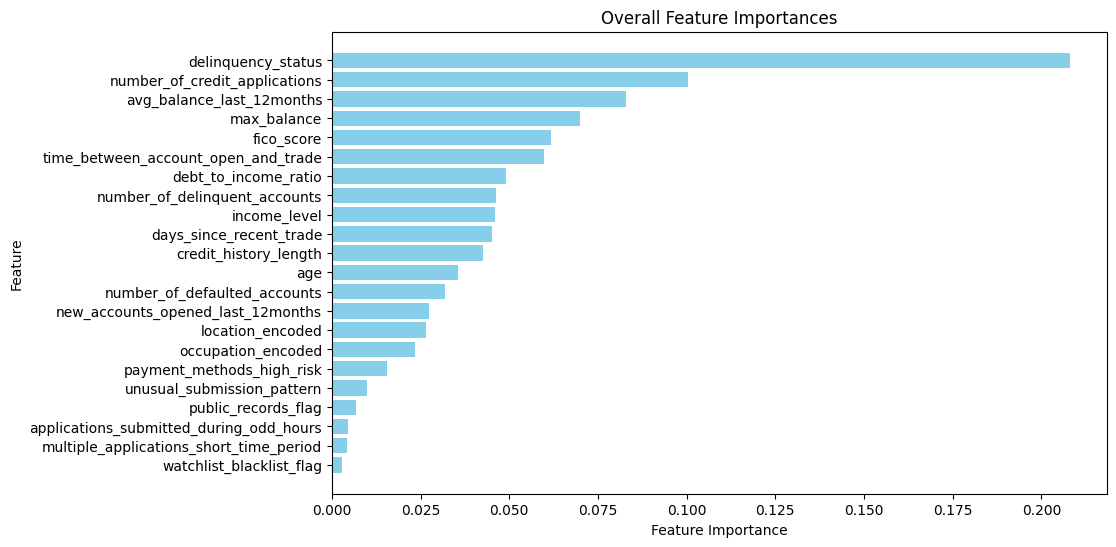

In [ ]:
#feature importances model
outlier_feature_importances = rf_outlier.feature_importances_
regular_feature_importances = rf_regular.feature_importances_

#calculate the average feature importance across both models
overall_feature_importances = (outlier_feature_importances + regular_feature_importances) / 2

feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(len(overall_feature_importances))]
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": overall_feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
print("Overall Feature Importances:")
print(importance_df)

#plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Overall Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
#model with only top 10 features

top_10_features = importance_df["Feature"].head(10).values

#training and test data to including only these top 10 features
X_outliers_train_top10 = X_outliers_train[top_10_features]
X_regular_train_top10 = X_regular_train[top_10_features]
X_outliers_test_top10 = X_outliers_test[top_10_features]
X_regular_test_top10 = X_regular_test[top_10_features]

#separate Random Forest models for outlier and regular clusters using only the top 10 features
rf_outlier_top10 = rf_outlier
rf_regular_top10 = rf_regular

#train models on respective clusters
rf_outlier_top10.fit(X_outliers_train_top10, y_outliers_train)
rf_regular_top10.fit(X_regular_train_top10, y_regular_train)

#evaluate the models
#outlier cluster predictions
outlier_test_preds_top10 = rf_outlier_top10.predict(X_outliers_test_top10)
outlier_test_accuracy_top10 = accuracy_score(y_outliers_test, outlier_test_preds_top10)
outlier_precision_top10 = precision_score(y_outliers_test, outlier_test_preds_top10, average='weighted')
outlier_recall_top10 = recall_score(y_outliers_test, outlier_test_preds_top10, average='weighted')
outlier_f1_top10 = f1_score(y_outliers_test, outlier_test_preds_top10, average='weighted')

#regular cluster predictions
regular_test_preds_top10 = rf_regular_top10.predict(X_regular_test_top10)
regular_test_accuracy_top10 = accuracy_score(y_regular_test, regular_test_preds_top10)
regular_precision_top10 = precision_score(y_regular_test, regular_test_preds_top10, average='weighted')
regular_recall_top10 = recall_score(y_regular_test, regular_test_preds_top10, average='weighted')
regular_f1_top10 = f1_score(y_regular_test, regular_test_preds_top10, average='weighted')

#combined overall accuracy for the test set with top 10 features
overall_test_preds_top10 = np.zeros(len(X_test), dtype=int)
overall_test_preds_top10[outlier_labels_test == -1] = outlier_test_preds_top10
overall_test_preds_top10[outlier_labels_test == 1] = regular_test_preds_top10

overall_accuracy_top10 = accuracy_score(y_test, overall_test_preds_top10)
overall_precision_top10 = precision_score(y_test, overall_test_preds_top10, average='weighted')
overall_recall_top10 = recall_score(y_test, overall_test_preds_top10, average='weighted')
overall_f1_top10 = f1_score(y_test, overall_test_preds_top10, average='weighted')

#print results
print("Evaluation metrics with Top 10 Features:")
print(f"Outlier cluster - Test Accuracy: {outlier_test_accuracy_top10}")
print(f"Outlier cluster - Precision: {outlier_precision_top10}, Recall: {outlier_recall_top10}, F1-Score: {outlier_f1_top10}")
print(f"Regular observations cluster - Test Accuracy: {regular_test_accuracy_top10}")
print(f"Regular observations cluster - Precision: {regular_precision_top10}, Recall: {regular_recall_top10}, F1-Score: {regular_f1_top10}")
print(f"Overall - Accuracy: {overall_accuracy_top10}, Precision: {overall_precision_top10}, Recall: {overall_recall_top10}, F1-Score: {overall_f1_top10}")

Evaluation metrics with Top 10 Features:
Outlier cluster - Test Accuracy: 0.816933638443936
Outlier cluster - Precision: 0.8276278616867719, Recall: 0.816933638443936, F1-Score: 0.812434618256322
Regular observations cluster - Test Accuracy: 0.8868120456905504
Regular observations cluster - Precision: 0.8684504445610578, Recall: 0.8868120456905504, F1-Score: 0.8456828849303591
Overall - Accuracy: 0.865, Precision: 0.8607146801767191, Recall: 0.865, F1-Score: 0.8611377009678642


In [ ]:
#model with only top 15 features

top_15_features = importance_df["Feature"].head(15).values

X_outliers_train_top15 = X_outliers_train[top_15_features]
X_regular_train_top15 = X_regular_train[top_15_features]
X_outliers_test_top15 = X_outliers_test[top_15_features]
X_regular_test_top15 = X_regular_test[top_15_features]

rf_outlier_top15 = rf_outlier
rf_regular_top15 = rf_regular

rf_outlier_top15.fit(X_outliers_train_top15, y_outliers_train)
rf_regular_top15.fit(X_regular_train_top15, y_regular_train)

outlier_test_preds_top15 = rf_outlier_top15.predict(X_outliers_test_top15)
outlier_test_accuracy_top15 = accuracy_score(y_outliers_test, outlier_test_preds_top15)
outlier_precision_top15 = precision_score(y_outliers_test, outlier_test_preds_top15, average='weighted')
outlier_recall_top15 = recall_score(y_outliers_test, outlier_test_preds_top15, average='weighted')
outlier_f1_top15 = f1_score(y_outliers_test, outlier_test_preds_top15, average='weighted')

regular_test_preds_top15 = rf_regular_top15.predict(X_regular_test_top15)
regular_test_accuracy_top15 = accuracy_score(y_regular_test, regular_test_preds_top15)
regular_precision_top15 = precision_score(y_regular_test, regular_test_preds_top15, average='weighted')
regular_recall_top15 = recall_score(y_regular_test, regular_test_preds_top15, average='weighted')
regular_f1_top15 = f1_score(y_regular_test, regular_test_preds_top15, average='weighted')

overall_test_preds_top15 = np.zeros(len(X_test), dtype=int)
overall_test_preds_top15[outlier_labels_test == -1] = outlier_test_preds_top15
overall_test_preds_top15[outlier_labels_test == 1] = regular_test_preds_top15

overall_accuracy_top15 = accuracy_score(y_test, overall_test_preds_top15)
overall_precision_top15 = precision_score(y_test, overall_test_preds_top15, average='weighted')
overall_recall_top15 = recall_score(y_test, overall_test_preds_top15, average='weighted')
overall_f1_top15 = f1_score(y_test, overall_test_preds_top15, average='weighted')

print("Evaluation metrics with Top 15 Features:")
print(f"Outlier cluster - Test Accuracy: {outlier_test_accuracy_top15}")
print(f"Outlier cluster - Precision: {outlier_precision_top15}, Recall: {outlier_recall_top15}, F1-Score: {outlier_f1_top15}")
print(f"Regular observations cluster - Test Accuracy: {regular_test_accuracy_top15}")
print(f"Regular observations cluster - Precision: {regular_precision_top15}, Recall: {regular_recall_top15}, F1-Score: {regular_f1_top15}")
print(f"Overall - Accuracy: {overall_accuracy_top15}, Precision: {overall_precision_top15}, Recall: {overall_recall_top15}, F1-Score: {overall_f1_top15}")

Evaluation metrics with Top 15 Features:
Outlier cluster - Test Accuracy: 0.8237986270022883
Outlier cluster - Precision: 0.8344013845110501, Recall: 0.8237986270022883, F1-Score: 0.8196105809653584
Regular observations cluster - Test Accuracy: 0.8888888888888888
Regular observations cluster - Precision: 0.8828718308213578, Recall: 0.8888888888888888, F1-Score: 0.8470128004427462
Overall - Accuracy: 0.8685714285714285, Precision: 0.8644616217098601, Recall: 0.8685714285714285, F1-Score: 0.8645775781850549


### after dropping number_of_delinquent_accounts


In [ ]:
X_train_drop1 = X_train.drop(columns=["number_of_delinquent_accounts"])
X_test_drop1 = X_test.drop(columns=["number_of_delinquent_accounts"])

In [ ]:
#initialize dictionary to store MCC values
mcc_vals = {}

In [ ]:
#RF model after dropping number_of_delinquent_accounts
np.random.seed(32)

iso_forest = IsolationForest(contamination=0.3, random_state=32)
outlier_labels_train = iso_forest.fit_predict(X_train_drop1)

X_outliers_train = X_train_drop1[outlier_labels_train == -1]
y_outliers_train = y_train[outlier_labels_train == -1]
X_regular_train = X_train_drop1[outlier_labels_train == 1]
y_regular_train = y_train[outlier_labels_train == 1]

outlier_labels_test = iso_forest.predict(X_test_drop1)
X_outliers_test = X_test_drop1[outlier_labels_test == -1]
y_outliers_test = y_test[outlier_labels_test == -1]
X_regular_test = X_test_drop1[outlier_labels_test == 1]
y_regular_test = y_test[outlier_labels_test == 1]

rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_outlier_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=32),
    rf_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
rf_outlier_search.fit(X_outliers_train, y_outliers_train)
rf_outlier = rf_outlier_search.best_estimator_

rf_regular_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=32),
    rf_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
rf_regular_search.fit(X_regular_train, y_regular_train)
rf_regular = rf_regular_search.best_estimator_

outlier_train_preds = rf_outlier.predict(X_outliers_train)
outlier_test_preds = rf_outlier.predict(X_outliers_test)
regular_train_preds = rf_regular.predict(X_regular_train)
regular_test_preds = rf_regular.predict(X_regular_test)

overall_test_preds = np.zeros(len(X_test), dtype=int)
overall_test_preds[outlier_labels_test == -1] = outlier_test_preds
overall_test_preds[outlier_labels_test == 1] = regular_test_preds

outlier_train_accuracy = accuracy_score(y_outliers_train, outlier_train_preds)
outlier_test_accuracy = accuracy_score(y_outliers_test, outlier_test_preds)
outlier_precision = precision_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_recall = recall_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_f1_macro = f1_score(y_outliers_test, outlier_test_preds, average='macro')
outlier_f1_weighted = f1_score(y_outliers_test, outlier_test_preds, average='weighted')

regular_train_accuracy = accuracy_score(y_regular_train, regular_train_preds)
regular_test_accuracy = accuracy_score(y_regular_test, regular_test_preds)
regular_precision = precision_score(y_regular_test, regular_test_preds, average='weighted')
regular_recall = recall_score(y_regular_test, regular_test_preds, average='weighted')
regular_f1_macro = f1_score(y_regular_test, regular_test_preds, average='macro')
regular_f1_weighted = f1_score(y_regular_test, regular_test_preds, average='weighted')

overall_accuracy = accuracy_score(y_test, overall_test_preds)
overall_precision = precision_score(y_test, overall_test_preds, average='weighted')
overall_recall = recall_score(y_test, overall_test_preds, average='weighted')
overall_f1_macro = f1_score(y_test, overall_test_preds, average='macro')
overall_f1_weighted = f1_score(y_test, overall_test_preds, average='weighted')

#MCC for outlier cluster
outlier_train_mcc = matthews_corrcoef(y_outliers_train, outlier_train_preds)
outlier_test_mcc = matthews_corrcoef(y_outliers_test, outlier_test_preds)

#MCC for regular observations cluster
regular_train_mcc = matthews_corrcoef(y_regular_train, regular_train_preds)
regular_test_mcc = matthews_corrcoef(y_regular_test, regular_test_preds)

#MCC for overall predictions
overall_mcc = matthews_corrcoef(y_test, overall_test_preds)

#append to MCC dictionary
mcc_vals["Random Forest"] = overall_mcc

print("Evaluation metrics – outlier cluster:")
print(f"Outlier cluster - Train Accuracy: {outlier_train_accuracy}, Test Accuracy: {outlier_test_accuracy}")
print(f"Outlier cluster - Precision (weighted): {outlier_precision}, Recall (weighted): {outlier_recall}")
print(f"Outlier cluster - F1-Score (macro): {outlier_f1_macro}, F1-Score (weighted): {outlier_f1_weighted}")

print("\nEvaluation metrics – regular observations cluster:")
print(f"Regular observations cluster - Train Accuracy: {regular_train_accuracy}, Test Accuracy: {regular_test_accuracy}")
print(f"Regular observations cluster - Precision (weighted): {regular_precision}, Recall (weighted): {regular_recall}")
print(f"Regular observations cluster - F1-Score (macro): {regular_f1_macro}, F1-Score (weighted): {regular_f1_weighted}")

print("\nOverall evaluation metrics:")
print(f"Overall - Accuracy: {overall_accuracy}")
print(f"Overall - Precision (weighted): {overall_precision}, Recall (weighted): {overall_recall}")
print(f"Overall - F1-Score (macro): {overall_f1_macro}, F1-Score (weighted): {overall_f1_weighted}")

Evaluation metrics – outlier cluster:
Outlier cluster - Train Accuracy: 0.8607142857142858, Test Accuracy: 0.8167053364269141
Outlier cluster - Precision (weighted): 0.8252785417083561, Recall (weighted): 0.8167053364269141
Outlier cluster - F1-Score (macro): 0.8058303917151868, F1-Score (weighted): 0.812120800911186

Evaluation metrics – regular observations cluster:
Regular observations cluster - Train Accuracy: 0.8969387755102041, Test Accuracy: 0.891640866873065
Regular observations cluster - Precision (weighted): 0.8868352297468715, Recall (weighted): 0.891640866873065
Regular observations cluster - F1-Score (macro): 0.5576246646695392, F1-Score (weighted): 0.8515747903617158

Overall evaluation metrics:
Overall - Accuracy: 0.8685714285714285
Overall - Precision (weighted): 0.8644616217098601, Recall (weighted): 0.8685714285714285
Overall - F1-Score (macro): 0.817615406400453, F1-Score (weighted): 0.8645775781850549


In [ ]:
#NB after dropping number_of delinquent_accounts
np.random.seed(32)

iso_forest = IsolationForest(contamination=0.3, random_state=32)
outlier_labels_train = iso_forest.fit_predict(X_train_drop1)

X_outliers_train = X_train_drop1[outlier_labels_train == -1]
y_outliers_train = y_train[outlier_labels_train == -1]
X_regular_train = X_train_drop1[outlier_labels_train == 1]
y_regular_train = y_train[outlier_labels_train == 1]

outlier_labels_test = iso_forest.predict(X_test_drop1)
X_outliers_test = X_test_drop1[outlier_labels_test == -1]
y_outliers_test = y_test[outlier_labels_test == -1]
X_regular_test = X_test_drop1[outlier_labels_test == 1]
y_regular_test = y_test[outlier_labels_test == 1]

nb_outlier = GaussianNB()
nb_outlier.fit(X_outliers_train, y_outliers_train)

nb_regular = GaussianNB()
nb_regular.fit(X_regular_train, y_regular_train)

outlier_train_preds = nb_outlier.predict(X_outliers_train)
outlier_test_preds = nb_outlier.predict(X_outliers_test)
regular_train_preds = nb_regular.predict(X_regular_train)
regular_test_preds = nb_regular.predict(X_regular_test)

overall_test_preds = np.zeros(len(X_test), dtype=int)
overall_test_preds[outlier_labels_test == -1] = outlier_test_preds
overall_test_preds[outlier_labels_test == 1] = regular_test_preds

outlier_train_accuracy = accuracy_score(y_outliers_train, outlier_train_preds)
outlier_test_accuracy = accuracy_score(y_outliers_test, outlier_test_preds)
outlier_precision = precision_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_recall = recall_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_f1_macro = f1_score(y_outliers_test, outlier_test_preds, average='macro')
outlier_f1_weighted = f1_score(y_outliers_test, outlier_test_preds, average='weighted')

regular_train_accuracy = accuracy_score(y_regular_train, regular_train_preds)
regular_test_accuracy = accuracy_score(y_regular_test, regular_test_preds)
regular_precision = precision_score(y_regular_test, regular_test_preds, average='weighted')
regular_recall = recall_score(y_regular_test, regular_test_preds, average='weighted')
regular_f1_macro = f1_score(y_regular_test, regular_test_preds, average='macro')
regular_f1_weighted = f1_score(y_regular_test, regular_test_preds, average='weighted')

overall_accuracy = accuracy_score(y_test, overall_test_preds)
overall_precision = precision_score(y_test, overall_test_preds, average='weighted')
overall_recall = recall_score(y_test, overall_test_preds, average='weighted')
overall_f1_macro = f1_score(y_test, overall_test_preds, average='macro')
overall_f1_weighted = f1_score(y_test, overall_test_preds, average='weighted')

outlier_train_mcc = matthews_corrcoef(y_outliers_train, outlier_train_preds)
outlier_test_mcc = matthews_corrcoef(y_outliers_test, outlier_test_preds)
regular_train_mcc = matthews_corrcoef(y_regular_train, regular_train_preds)
regular_test_mcc = matthews_corrcoef(y_regular_test, regular_test_preds)

overall_mcc = matthews_corrcoef(y_test, overall_test_preds)
mcc_vals["Naive Bayes"] = overall_mcc

print("Evaluation metrics – outlier cluster:")
print(f"Outlier cluster - Train Accuracy: {outlier_train_accuracy}, Test Accuracy: {outlier_test_accuracy}")
print(f"Outlier cluster - Precision (weighted): {outlier_precision}, Recall (weighted): {outlier_recall}")
print(f"Outlier cluster - F1-Score (macro): {outlier_f1_macro}, F1-Score (weighted): {outlier_f1_weighted}")

print("\nEvaluation metrics – regular observations cluster:")
print(f"Regular observations cluster - Train Accuracy: {regular_train_accuracy}, Test Accuracy: {regular_test_accuracy}")
print(f"Regular observations cluster - Precision (weighted): {regular_precision}, Recall (weighted): {regular_recall}")
print(f"Regular observations cluster - F1-Score (macro): {regular_f1_macro}, F1-Score (weighted): {regular_f1_weighted}")

print("\nOverall evaluation metrics:")
print(f"Overall - Accuracy: {overall_accuracy}")
print(f"Overall - Precision (weighted): {overall_precision}, Recall (weighted): {overall_recall}")
print(f"Overall - F1-Score (macro): {overall_f1_macro}, F1-Score (weighted): {overall_f1_weighted}")

Evaluation metrics – outlier cluster:
Outlier cluster - Train Accuracy: 0.7976190476190477, Test Accuracy: 0.8074245939675174
Outlier cluster - Precision (weighted): 0.815295276069638, Recall (weighted): 0.8074245939675174
Outlier cluster - F1-Score (macro): 0.7959990191438038, F1-Score (weighted): 0.8026079300712461

Evaluation metrics – regular observations cluster:
Regular observations cluster - Train Accuracy: 0.878061224489796, Test Accuracy: 0.8813209494324046
Regular observations cluster - Precision (weighted): 0.8487005056053276, Recall (weighted): 0.8813209494324046
Regular observations cluster - F1-Score (macro): 0.587028465332775, F1-Score (weighted): 0.85361860068464

Overall evaluation metrics:
Overall - Accuracy: 0.8585714285714285
Overall - Precision (weighted): 0.8550645540506006, Recall (weighted): 0.8585714285714285
Overall - F1-Score (macro): 0.8084767684807481, F1-Score (weighted): 0.8561926318632118


In [ ]:
#MLP after dropping number_of_delinquent_accounts
np.random.seed(32)

iso_forest = IsolationForest(contamination=0.3, random_state=32)
outlier_labels_train = iso_forest.fit_predict(X_train_drop1)

X_outliers_train = X_train_drop1[outlier_labels_train == -1]
y_outliers_train = y_train[outlier_labels_train == -1]
X_regular_train = X_train_drop1[outlier_labels_train == 1]
y_regular_train = y_train[outlier_labels_train == 1]

outlier_labels_test = iso_forest.predict(X_test_drop1)
X_outliers_test = X_test_drop1[outlier_labels_test == -1]
y_outliers_test = y_test[outlier_labels_test == -1]
X_regular_test = X_test_drop1[outlier_labels_test == 1]
y_regular_test = y_test[outlier_labels_test == 1]

mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 300, 400]
}

mlp_outlier_search = RandomizedSearchCV(
    MLPClassifier(random_state=32),
    mlp_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
mlp_outlier_search.fit(X_outliers_train, y_outliers_train)
mlp_outlier = mlp_outlier_search.best_estimator_

mlp_regular_search = RandomizedSearchCV(
    MLPClassifier(random_state=32),
    mlp_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
mlp_regular_search.fit(X_regular_train, y_regular_train)
mlp_regular = mlp_regular_search.best_estimator_

outlier_train_preds = mlp_outlier.predict(X_outliers_train)
outlier_test_preds = mlp_outlier.predict(X_outliers_test)
regular_train_preds = mlp_regular.predict(X_regular_train)
regular_test_preds = mlp_regular.predict(X_regular_test)

overall_test_preds = np.zeros(len(X_test), dtype=int)
overall_test_preds[outlier_labels_test == -1] = outlier_test_preds
overall_test_preds[outlier_labels_test == 1] = regular_test_preds

outlier_train_accuracy = accuracy_score(y_outliers_train, outlier_train_preds)
outlier_test_accuracy = accuracy_score(y_outliers_test, outlier_test_preds)
outlier_precision = precision_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_recall = recall_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_f1_macro = f1_score(y_outliers_test, outlier_test_preds, average='macro')
outlier_f1_weighted = f1_score(y_outliers_test, outlier_test_preds, average='weighted')

regular_train_accuracy = accuracy_score(y_regular_train, regular_train_preds)
regular_test_accuracy = accuracy_score(y_regular_test, regular_test_preds)
regular_precision = precision_score(y_regular_test, regular_test_preds, average='weighted')
regular_recall = recall_score(y_regular_test, regular_test_preds, average='weighted')
regular_f1_macro = f1_score(y_regular_test, regular_test_preds, average='macro')
regular_f1_weighted = f1_score(y_regular_test, regular_test_preds, average='weighted')

overall_accuracy = accuracy_score(y_test, overall_test_preds)
overall_precision = precision_score(y_test, overall_test_preds, average='weighted')
overall_recall = recall_score(y_test, overall_test_preds, average='weighted')
overall_f1_macro = f1_score(y_test, overall_test_preds, average='macro')
overall_f1_weighted = f1_score(y_test, overall_test_preds, average='weighted')

outlier_train_mcc = matthews_corrcoef(y_outliers_train, outlier_train_preds)
outlier_test_mcc = matthews_corrcoef(y_outliers_test, outlier_test_preds)
regular_train_mcc = matthews_corrcoef(y_regular_train, regular_train_preds)
regular_test_mcc = matthews_corrcoef(y_regular_test, regular_test_preds)

overall_mcc = matthews_corrcoef(y_test, overall_test_preds)
mcc_vals["Multi Layer Perceptron"] = overall_mcc

print("Evaluation metrics – outlier cluster:")
print(f"Outlier cluster - Train Accuracy: {outlier_train_accuracy}, Test Accuracy: {outlier_test_accuracy}")
print(f"Outlier cluster - Precision (weighted): {outlier_precision}, Recall (weighted): {outlier_recall}")
print(f"Outlier cluster - F1-Score (macro): {outlier_f1_macro}, F1-Score (weighted): {outlier_f1_weighted}")

print("\nEvaluation metrics – regular observations cluster:")
print(f"Regular observations cluster - Train Accuracy: {regular_train_accuracy}, Test Accuracy: {regular_test_accuracy}")
print(f"Regular observations cluster - Precision (weighted): {regular_precision}, Recall (weighted): {regular_recall}")
print(f"Regular observations cluster - F1-Score (macro): {regular_f1_macro}, F1-Score (weighted): {regular_f1_weighted}")

print("\nOverall evaluation metrics:")
print(f"Overall - Accuracy: {overall_accuracy}")
print(f"Overall - Precision (weighted): {overall_precision}, Recall (weighted): {overall_recall}")
print(f"Overall - F1-Score (macro): {overall_f1_macro}, F1-Score (weighted): {overall_f1_weighted}")

Evaluation metrics – outlier cluster:
Outlier cluster - Train Accuracy: 0.7607142857142857, Test Accuracy: 0.7679814385150812
Outlier cluster - Precision (weighted): 0.7692798461056312, Recall (weighted): 0.7679814385150812
Outlier cluster - F1-Score (macro): 0.7571557358575615, F1-Score (weighted): 0.7641745980201292

Evaluation metrics – regular observations cluster:
Regular observations cluster - Train Accuracy: 0.8816326530612245, Test Accuracy: 0.8823529411764706
Regular observations cluster - Precision (weighted): 0.7785467128027681, Recall (weighted): 0.8823529411764706
Regular observations cluster - F1-Score (macro): 0.46875, F1-Score (weighted): 0.8272058823529411

Overall evaluation metrics:
Overall - Accuracy: 0.8471428571428572
Overall - Precision (weighted): 0.8409063296068835, Recall (weighted): 0.8471428571428572
Overall - F1-Score (macro): 0.7823155349399551, F1-Score (weighted): 0.8401849508331215


In [ ]:
#Gradient Boost after dropping number_of_delinqent_accounts
np.random.seed(32)

iso_forest = IsolationForest(contamination=0.3, random_state=32)
outlier_labels_train = iso_forest.fit_predict(X_train_drop1)

X_outliers_train = X_train_drop1[outlier_labels_train == -1]
y_outliers_train = y_train[outlier_labels_train == -1]
X_regular_train = X_train_drop1[outlier_labels_train == 1]
y_regular_train = y_train[outlier_labels_train == 1]

outlier_labels_test = iso_forest.predict(X_test_drop1)
X_outliers_test = X_test_drop1[outlier_labels_test == -1]
y_outliers_test = y_test[outlier_labels_test == -1]
X_regular_test = X_test_drop1[outlier_labels_test == 1]
y_regular_test = y_test[outlier_labels_test == 1]

gb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}

gb_outlier_search = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=32),
    gb_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
gb_outlier_search.fit(X_outliers_train, y_outliers_train)
gb_outlier = gb_outlier_search.best_estimator_

gb_regular_search = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=32),
    gb_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
gb_regular_search.fit(X_regular_train, y_regular_train)
gb_regular = gb_regular_search.best_estimator_

outlier_train_preds = gb_outlier.predict(X_outliers_train)
outlier_test_preds = gb_outlier.predict(X_outliers_test)
regular_train_preds = gb_regular.predict(X_regular_train)
regular_test_preds = gb_regular.predict(X_regular_test)

overall_test_preds = np.zeros(len(X_test), dtype=int)
overall_test_preds[outlier_labels_test == -1] = outlier_test_preds
overall_test_preds[outlier_labels_test == 1] = regular_test_preds

outlier_train_accuracy = accuracy_score(y_outliers_train, outlier_train_preds)
outlier_test_accuracy = accuracy_score(y_outliers_test, outlier_test_preds)
outlier_precision = precision_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_recall = recall_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_f1_macro = f1_score(y_outliers_test, outlier_test_preds, average='macro')
outlier_f1_weighted = f1_score(y_outliers_test, outlier_test_preds, average='weighted')

regular_train_accuracy = accuracy_score(y_regular_train, regular_train_preds)
regular_test_accuracy = accuracy_score(y_regular_test, regular_test_preds)
regular_precision = precision_score(y_regular_test, regular_test_preds, average='weighted')
regular_recall = recall_score(y_regular_test, regular_test_preds, average='weighted')
regular_f1_macro = f1_score(y_regular_test, regular_test_preds, average='macro')
regular_f1_weighted = f1_score(y_regular_test, regular_test_preds, average='weighted')

overall_accuracy = accuracy_score(y_test, overall_test_preds)
overall_precision = precision_score(y_test, overall_test_preds, average='weighted')
overall_recall = recall_score(y_test, overall_test_preds, average='weighted')
overall_f1_macro = f1_score(y_test, overall_test_preds, average='macro')
overall_f1_weighted = f1_score(y_test, overall_test_preds, average='weighted')

outlier_train_mcc = matthews_corrcoef(y_outliers_train, outlier_train_preds)
outlier_test_mcc = matthews_corrcoef(y_outliers_test, outlier_test_preds)
regular_train_mcc = matthews_corrcoef(y_regular_train, regular_train_preds)
regular_test_mcc = matthews_corrcoef(y_regular_test, regular_test_preds)

overall_mcc = matthews_corrcoef(y_test, overall_test_preds)
mcc_vals["Gradient Boosting"] = overall_mcc

print("Evaluation metrics – outlier cluster:")
print(f"Outlier cluster - Train Accuracy: {outlier_train_accuracy}, Test Accuracy: {outlier_test_accuracy}")
print(f"Outlier cluster - Precision (weighted): {outlier_precision}, Recall (weighted): {outlier_recall}")
print(f"Outlier cluster - F1-Score (macro): {outlier_f1_macro}, F1-Score (weighted): {outlier_f1_weighted}")

print("\nEvaluation metrics – regular observations cluster:")
print(f"Regular observations cluster - Train Accuracy: {regular_train_accuracy}, Test Accuracy: {regular_test_accuracy}")
print(f"Regular observations cluster - Precision (weighted): {regular_precision}, Recall (weighted): {regular_recall}")
print(f"Regular observations cluster - F1-Score (macro): {regular_f1_macro}, F1-Score (weighted): {regular_f1_weighted}")

print("\nOverall evaluation metrics:")
print(f"Overall - Accuracy: {overall_accuracy}")
print(f"Overall - Precision (weighted): {overall_precision}, Recall (weighted): {overall_recall}")
print(f"Overall - F1-Score (macro): {overall_f1_macro}, F1-Score (weighted): {overall_f1_weighted}")

Evaluation metrics – outlier cluster:
Outlier cluster - Train Accuracy: 0.8220238095238095, Test Accuracy: 0.8074245939675174
Outlier cluster - Precision (weighted): 0.8175777211876368, Recall (weighted): 0.8074245939675174
Outlier cluster - F1-Score (macro): 0.7950265005013608, F1-Score (weighted): 0.8019273261098818

Evaluation metrics – regular observations cluster:
Regular observations cluster - Train Accuracy: 0.8946428571428572, Test Accuracy: 0.890608875128999
Regular observations cluster - Precision (weighted): 0.884504271928207, Recall (weighted): 0.890608875128999
Regular observations cluster - F1-Score (macro): 0.550115631241459, F1-Score (weighted): 0.8494104043383358

Overall evaluation metrics:
Overall - Accuracy: 0.865
Overall - Precision (weighted): 0.8607146801767191, Recall (weighted): 0.865
Overall - F1-Score (macro): 0.8132451929693802, F1-Score (weighted): 0.8611377009678642


In [ ]:
#adaboost after dropping number_of_delinquent_accounts
np.random.seed(32)

iso_forest = IsolationForest(contamination=0.3, random_state=32)
outlier_labels_train = iso_forest.fit_predict(X_train_drop1)

X_outliers_train = X_train_drop1[outlier_labels_train == -1]
y_outliers_train = y_train[outlier_labels_train == -1]
X_regular_train = X_train_drop1[outlier_labels_train == 1]
y_regular_train = y_train[outlier_labels_train == 1]

outlier_labels_test = iso_forest.predict(X_test_drop1)
X_outliers_test = X_test_drop1[outlier_labels_test == -1]
y_outliers_test = y_test[outlier_labels_test == -1]
X_regular_test = X_test_drop1[outlier_labels_test == 1]
y_regular_test = y_test[outlier_labels_test == 1]

adaboost_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1, 2],
    'algorithm': ['SAMME', 'SAMME.R']
}

adaboost_outlier_search = RandomizedSearchCV(
    AdaBoostClassifier(random_state=32),
    adaboost_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
adaboost_outlier_search.fit(X_outliers_train, y_outliers_train)
adaboost_outlier = adaboost_outlier_search.best_estimator_

adaboost_regular_search = RandomizedSearchCV(
    AdaBoostClassifier(random_state=32),
    adaboost_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
adaboost_regular_search.fit(X_regular_train, y_regular_train)
adaboost_regular = adaboost_regular_search.best_estimator_

outlier_train_preds = adaboost_outlier.predict(X_outliers_train)
outlier_test_preds = adaboost_outlier.predict(X_outliers_test)
regular_train_preds = adaboost_regular.predict(X_regular_train)
regular_test_preds = adaboost_regular.predict(X_regular_test)

overall_test_preds = np.zeros(len(X_test), dtype=int)
overall_test_preds[outlier_labels_test == -1] = outlier_test_preds
overall_test_preds[outlier_labels_test == 1] = regular_test_preds

outlier_train_accuracy = accuracy_score(y_outliers_train, outlier_train_preds)
outlier_test_accuracy = accuracy_score(y_outliers_test, outlier_test_preds)
outlier_precision = precision_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_recall = recall_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_f1_macro = f1_score(y_outliers_test, outlier_test_preds, average='macro')
outlier_f1_weighted = f1_score(y_outliers_test, outlier_test_preds, average='weighted')

regular_train_accuracy = accuracy_score(y_regular_train, regular_train_preds)
regular_test_accuracy = accuracy_score(y_regular_test, regular_test_preds)
regular_precision = precision_score(y_regular_test, regular_test_preds, average='weighted')
regular_recall = recall_score(y_regular_test, regular_test_preds, average='weighted')
regular_f1_macro = f1_score(y_regular_test, regular_test_preds, average='macro')
regular_f1_weighted = f1_score(y_regular_test, regular_test_preds, average='weighted')

overall_accuracy = accuracy_score(y_test, overall_test_preds)
overall_precision = precision_score(y_test, overall_test_preds, average='weighted')
overall_recall = recall_score(y_test, overall_test_preds, average='weighted')
overall_f1_macro = f1_score(y_test, overall_test_preds, average='macro')
overall_f1_weighted = f1_score(y_test, overall_test_preds, average='weighted')

outlier_train_mcc = matthews_corrcoef(y_outliers_train, outlier_train_preds)
outlier_test_mcc = matthews_corrcoef(y_outliers_test, outlier_test_preds)
regular_train_mcc = matthews_corrcoef(y_regular_train, regular_train_preds)
regular_test_mcc = matthews_corrcoef(y_regular_test, regular_test_preds)

overall_mcc = matthews_corrcoef(y_test, overall_test_preds)
mcc_vals["AdaBoost"] = overall_mcc

print("Evaluation metrics – outlier cluster:")
print(f"Outlier cluster - Train Accuracy: {outlier_train_accuracy}, Test Accuracy: {outlier_test_accuracy}")
print(f"Outlier cluster - Precision (weighted): {outlier_precision}, Recall (weighted): {outlier_recall}")
print(f"Outlier cluster - F1-Score (macro): {outlier_f1_macro}, F1-Score (weighted): {outlier_f1_weighted}")

print("\nEvaluation metrics – regular observations cluster:")
print(f"Regular observations cluster - Train Accuracy: {regular_train_accuracy}, Test Accuracy: {regular_test_accuracy}")
print(f"Regular observations cluster - Precision (weighted): {regular_precision}, Recall (weighted): {regular_recall}")
print(f"Regular observations cluster - F1-Score (macro): {regular_f1_macro}, F1-Score (weighted): {regular_f1_weighted}")

print("\nOverall evaluation metrics:")
print(f"Overall - Accuracy: {overall_accuracy}")
print(f"Overall - Precision (weighted): {overall_precision}, Recall (weighted): {overall_recall}")
print(f"Overall - F1-Score (macro): {overall_f1_macro}, F1-Score (weighted): {overall_f1_weighted}")

Evaluation metrics – outlier cluster:
Outlier cluster - Train Accuracy: 0.8130952380952381, Test Accuracy: 0.8167053364269141
Outlier cluster - Precision (weighted): 0.8241971805296873, Recall (weighted): 0.8167053364269141
Outlier cluster - F1-Score (macro): 0.8062767052986726, F1-Score (weighted): 0.8124295976643351

Evaluation metrics – regular observations cluster:
Regular observations cluster - Train Accuracy: 0.8913265306122449, Test Accuracy: 0.891640866873065
Regular observations cluster - Precision (weighted): 0.8868352297468715, Recall (weighted): 0.891640866873065
Regular observations cluster - F1-Score (macro): 0.5576246646695392, F1-Score (weighted): 0.8515747903617158

Overall evaluation metrics:
Overall - Accuracy: 0.8685714285714285
Overall - Precision (weighted): 0.864433592707494, Recall (weighted): 0.8685714285714285
Overall - F1-Score (macro): 0.8172318572819198, F1-Score (weighted): 0.8644199807582608


In [ ]:
#knn after dropping number_of_delinquent_accounts
np.random.seed(32)

iso_forest = IsolationForest(contamination=0.3, random_state=32)
outlier_labels_train = iso_forest.fit_predict(X_train_drop1)

X_outliers_train = X_train_drop1[outlier_labels_train == -1]
y_outliers_train = y_train[outlier_labels_train == -1]
X_regular_train = X_train_drop1[outlier_labels_train == 1]
y_regular_train = y_train[outlier_labels_train == 1]

outlier_labels_test = iso_forest.predict(X_test_drop1)
X_outliers_test = X_test_drop1[outlier_labels_test == -1]
y_outliers_test = y_test[outlier_labels_test == -1]
X_regular_test = X_test_drop1[outlier_labels_test == 1]
y_regular_test = y_test[outlier_labels_test == 1]

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

knn_outlier_search = RandomizedSearchCV(
    KNeighborsClassifier(),
    knn_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
knn_outlier_search.fit(X_outliers_train, y_outliers_train)
knn_outlier = knn_outlier_search.best_estimator_

knn_regular_search = RandomizedSearchCV(
    KNeighborsClassifier(),
    knn_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
knn_regular_search.fit(X_regular_train, y_regular_train)
knn_regular = knn_regular_search.best_estimator_

outlier_train_preds = knn_outlier.predict(X_outliers_train)
outlier_test_preds = knn_outlier.predict(X_outliers_test)
regular_train_preds = knn_regular.predict(X_regular_train)
regular_test_preds = knn_regular.predict(X_regular_test)

overall_test_preds = np.zeros(len(X_test), dtype=int)
overall_test_preds[outlier_labels_test == -1] = outlier_test_preds
overall_test_preds[outlier_labels_test == 1] = regular_test_preds

outlier_train_accuracy = accuracy_score(y_outliers_train, outlier_train_preds)
outlier_test_accuracy = accuracy_score(y_outliers_test, outlier_test_preds)
outlier_precision = precision_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_recall = recall_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_f1_macro = f1_score(y_outliers_test, outlier_test_preds, average='macro')
outlier_f1_weighted = f1_score(y_outliers_test, outlier_test_preds, average='weighted')

regular_train_accuracy = accuracy_score(y_regular_train, regular_train_preds)
regular_test_accuracy = accuracy_score(y_regular_test, regular_test_preds)
regular_precision = precision_score(y_regular_test, regular_test_preds, average='weighted')
regular_recall = recall_score(y_regular_test, regular_test_preds, average='weighted')
regular_f1_macro = f1_score(y_regular_test, regular_test_preds, average='macro')
regular_f1_weighted = f1_score(y_regular_test, regular_test_preds, average='weighted')

overall_accuracy = accuracy_score(y_test, overall_test_preds)
overall_precision = precision_score(y_test, overall_test_preds, average='weighted')
overall_recall = recall_score(y_test, overall_test_preds, average='weighted')
overall_f1_macro = f1_score(y_test, overall_test_preds, average='macro')
overall_f1_weighted = f1_score(y_test, overall_test_preds, average='weighted')

outlier_train_mcc = matthews_corrcoef(y_outliers_train, outlier_train_preds)
outlier_test_mcc = matthews_corrcoef(y_outliers_test, outlier_test_preds)
regular_train_mcc = matthews_corrcoef(y_regular_train, regular_train_preds)
regular_test_mcc = matthews_corrcoef(y_regular_test, regular_test_preds)

overall_mcc = matthews_corrcoef(y_test, overall_test_preds)
mcc_vals["k-Nearest Neighbours"] = overall_mcc

print("Evaluation metrics – outlier cluster:")
print(f"Outlier cluster - Train Accuracy: {outlier_train_accuracy}, Test Accuracy: {outlier_test_accuracy}")
print(f"Outlier cluster - Precision (weighted): {outlier_precision}, Recall (weighted): {outlier_recall}")
print(f"Outlier cluster - F1-Score (macro): {outlier_f1_macro}, F1-Score (weighted): {outlier_f1_weighted}")

print("\nEvaluation metrics – regular observations cluster:")
print(f"Regular observations cluster - Train Accuracy: {regular_train_accuracy}, Test Accuracy: {regular_test_accuracy}")
print(f"Regular observations cluster - Precision (weighted): {regular_precision}, Recall (weighted): {regular_recall}")
print(f"Regular observations cluster - F1-Score (macro): {regular_f1_macro}, F1-Score (weighted): {regular_f1_weighted}")

print("\nOverall evaluation metrics:")
print(f"Overall - Accuracy: {overall_accuracy}")
print(f"Overall - Precision (weighted): {overall_precision}, Recall (weighted): {overall_recall}")
print(f"Overall - F1-Score (macro): {overall_f1_macro}, F1-Score (weighted): {overall_f1_weighted}")

Evaluation metrics – outlier cluster:
Outlier cluster - Train Accuracy: 1.0, Test Accuracy: 0.7703016241299304
Outlier cluster - Precision (weighted): 0.7738194163322661, Recall (weighted): 0.7703016241299304
Outlier cluster - F1-Score (macro): 0.7577785725233741, F1-Score (weighted): 0.7653179607354845

Evaluation metrics – regular observations cluster:
Regular observations cluster - Train Accuracy: 0.885969387755102, Test Accuracy: 0.8854489164086687
Regular observations cluster - Precision (weighted): 0.8757871613375641, Recall (weighted): 0.8854489164086687
Regular observations cluster - F1-Score (macro): 0.5031021754496191, F1-Score (weighted): 0.8364185696268612

Overall evaluation metrics:
Overall - Accuracy: 0.85
Overall - Precision (weighted): 0.8441899034194077, Recall (weighted): 0.85
Overall - F1-Score (macro): 0.7891711414016247, F1-Score (weighted): 0.8443377392262151


In [ ]:
#xgb after dropping number_of_delinquent_accounts
np.random.seed(32)

#initialize IsolationForest
iso_forest = IsolationForest(contamination=0.3, random_state=32)
outlier_labels_train = iso_forest.fit_predict(X_train_drop1)

#separate training data into outlier and regular clusters
X_outliers_train = X_train_drop1[outlier_labels_train == -1]
y_outliers_train = y_train[outlier_labels_train == -1]
X_regular_train = X_train_drop1[outlier_labels_train == 1]
y_regular_train = y_train[outlier_labels_train == 1]

#apply IsolationForest to the test set
outlier_labels_test = iso_forest.predict(X_test_drop1)
X_outliers_test = X_test_drop1[outlier_labels_test == -1]
y_outliers_test = y_test[outlier_labels_test == -1]
X_regular_test = X_test_drop1[outlier_labels_test == 1]
y_regular_test = y_test[outlier_labels_test == 1]

#parameter grid for XGBoostClassifier
xgb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

#RandomizedSearchCV for outlier cluster
xgb_outlier_search = RandomizedSearchCV(
    XGBClassifier(random_state=28),
    xgb_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
xgb_outlier_search.fit(X_outliers_train, y_outliers_train)
xgb_outlier = xgb_outlier_search.best_estimator_

#RandomizedSearchCV for regular cluster
xgb_regular_search = RandomizedSearchCV(
    XGBClassifier(random_state=28),
    xgb_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
xgb_regular_search.fit(X_regular_train, y_regular_train)
xgb_regular = xgb_regular_search.best_estimator_

#predict and calculate evaluation metrics for each cluster
outlier_train_preds = xgb_outlier.predict(X_outliers_train)
outlier_test_preds = xgb_outlier.predict(X_outliers_test)
regular_train_preds = xgb_regular.predict(X_regular_train)
regular_test_preds = xgb_regular.predict(X_regular_test)

#combined overall predictions for the test set
overall_test_preds = np.zeros(len(X_test), dtype=int)
overall_test_preds[outlier_labels_test == -1] = outlier_test_preds
overall_test_preds[outlier_labels_test == 1] = regular_test_preds

#evaluation metrics
outlier_train_accuracy = accuracy_score(y_outliers_train, outlier_train_preds)
outlier_test_accuracy = accuracy_score(y_outliers_test, outlier_test_preds)
outlier_precision = precision_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_recall = recall_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_f1_macro = f1_score(y_outliers_test, outlier_test_preds, average='macro')
outlier_f1_weighted = f1_score(y_outliers_test, outlier_test_preds, average='weighted')

regular_train_accuracy = accuracy_score(y_regular_train, regular_train_preds)
regular_test_accuracy = accuracy_score(y_regular_test, regular_test_preds)
regular_precision = precision_score(y_regular_test, regular_test_preds, average='weighted')
regular_recall = recall_score(y_regular_test, regular_test_preds, average='weighted')
regular_f1_macro = f1_score(y_regular_test, regular_test_preds, average='macro')
regular_f1_weighted = f1_score(y_regular_test, regular_test_preds, average='weighted')

overall_accuracy = accuracy_score(y_test, overall_test_preds)
overall_precision = precision_score(y_test, overall_test_preds, average='weighted')
overall_recall = recall_score(y_test, overall_test_preds, average='weighted')
overall_f1_macro = f1_score(y_test, overall_test_preds, average='macro')
overall_f1_weighted = f1_score(y_test, overall_test_preds, average='weighted')

outlier_train_mcc = matthews_corrcoef(y_outliers_train, outlier_train_preds)
outlier_test_mcc = matthews_corrcoef(y_outliers_test, outlier_test_preds)
regular_train_mcc = matthews_corrcoef(y_regular_train, regular_train_preds)
regular_test_mcc = matthews_corrcoef(y_regular_test, regular_test_preds)

overall_mcc = matthews_corrcoef(y_test, overall_test_preds)
mcc_vals["XGBoost"] = overall_mcc

#print results
print("Evaluation metrics – outlier cluster:")
print(f"Outlier cluster - Train Accuracy: {outlier_train_accuracy}, Test Accuracy: {outlier_test_accuracy}")
print(f"Outlier cluster - Precision (weighted): {outlier_precision}, Recall (weighted): {outlier_recall}")
print(f"Outlier cluster - F1-Score (macro): {outlier_f1_macro}, F1-Score (weighted): {outlier_f1_weighted}")

print("\nEvaluation metrics – regular observations cluster:")
print(f"Regular observations cluster - Train Accuracy: {regular_train_accuracy}, Test Accuracy: {regular_test_accuracy}")
print(f"Regular observations cluster - Precision (weighted): {regular_precision}, Recall (weighted): {regular_recall}")
print(f"Regular observations cluster - F1-Score (macro): {regular_f1_macro}, F1-Score (weighted): {regular_f1_weighted}")

print("\nOverall evaluation metrics:")
print(f"Overall - Accuracy: {overall_accuracy}")
print(f"Overall - Precision (weighted): {overall_precision}, Recall (weighted): {overall_recall}")
print(f"Overall - F1-Score (macro): {overall_f1_macro}, F1-Score (weighted): {overall_f1_weighted}")

Evaluation metrics – outlier cluster:
Outlier cluster - Train Accuracy: 0.8166666666666667, Test Accuracy: 0.814385150812065
Outlier cluster - Precision (weighted): 0.8233456649142682, Recall (weighted): 0.814385150812065
Outlier cluster - F1-Score (macro): 0.8031424134466063, F1-Score (weighted): 0.8095824280540049

Evaluation metrics – regular observations cluster:
Regular observations cluster - Train Accuracy: 0.8951530612244898, Test Accuracy: 0.890608875128999
Regular observations cluster - Precision (weighted): 0.884504271928207, Recall (weighted): 0.890608875128999
Regular observations cluster - F1-Score (macro): 0.550115631241459, F1-Score (weighted): 0.8494104043383358

Overall evaluation metrics:
Overall - Accuracy: 0.8671428571428571
Overall - Precision (weighted): 0.8629331104386652, Recall (weighted): 0.8671428571428571
Overall - F1-Score (macro): 0.8156329651656754, F1-Score (weighted): 0.8631055953392401


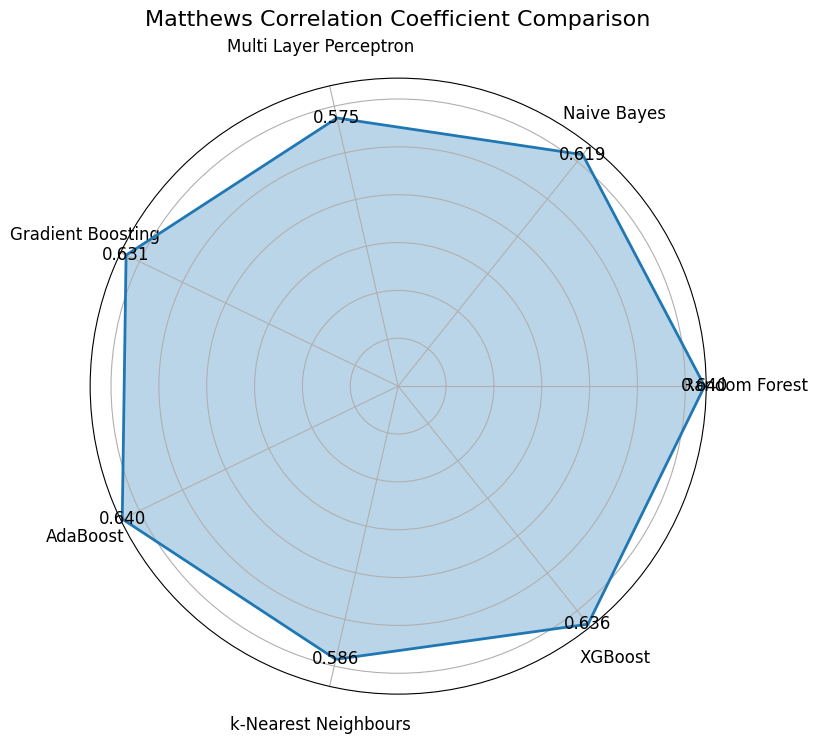

In [38]:
#MCC values plot
#extract models and MCC values from the dictionary
models = list(mcc_vals.keys())
mcc_values = list(mcc_vals.values())

num_models = len(models)

#calculate angle for each model
angles = np.linspace(0, 2 * np.pi, num_models, endpoint=False).tolist()

#make plot circular
mcc_values += mcc_values[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, mcc_values, linewidth=2, linestyle='solid')

#fill the area under the curve
ax.fill(angles, mcc_values, alpha=0.3)

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(models, fontsize=12)

ax.tick_params(axis='x', pad=18)

#MCC values at each point with padding
padding = 0.2
for i in range(num_models):
    ax.text(angles[i], mcc_values[i] , f"{mcc_values[i]:.3f}", ha='center', va='center', fontsize=12)

ax.set_title("Matthews Correlation Coefficient Comparison", size=16, color="black", va="bottom")
plt.show()

In [ ]:
#create copies of the datasets
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
y_train_copy = y_train.copy()
y_test_copy = y_test.copy()

In [ ]:
smote = SMOTE(random_state=32)
X_regular_train_smote, y_regular_train_smote = smote.fit_resample(X_regular_train, y_regular_train)

#hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

#train the Random Forest model for regular observations with SMOTE and hyperparameter tuning
rf_regular_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=32),
    rf_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
rf_regular_search.fit(X_regular_train_smote, y_regular_train_smote)

#best model for regular observations after hyperparameter tuning
rf_regular_smote = rf_regular_search.best_estimator_

#predict and evaluate metrics for the regular cluster after SMOTE
regular_train_preds_smote = rf_regular_smote.predict(X_regular_train_smote)
regular_test_preds_smote = rf_regular_smote.predict(X_regular_test)

regular_train_accuracy_smote = accuracy_score(y_regular_train_smote, regular_train_preds_smote)
regular_test_accuracy_smote = accuracy_score(y_regular_test, regular_test_preds_smote)
regular_precision_smote = precision_score(y_regular_test, regular_test_preds_smote, average='weighted')
regular_recall_smote = recall_score(y_regular_test, regular_test_preds_smote, average='weighted')
regular_f1_smote = f1_score(y_regular_test, regular_test_preds_smote, average='weighted')

#apply Random Forest with SMOTE to outlier observations with hyperparameter tuning
rf_outlier_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=32),
    rf_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
rf_outlier_search.fit(X_outliers_train, y_outliers_train)

#best model for outliers after hyperparameter tuning
rf_outlier_smote = rf_outlier_search.best_estimator_

#predict and evaluate metrics for the outlier cluster after SMOTE
outlier_train_preds_smote = rf_outlier_smote.predict(X_outliers_train)
outlier_test_preds_smote = rf_outlier_smote.predict(X_outliers_test)

outlier_train_accuracy_smote = accuracy_score(y_outliers_train, outlier_train_preds_smote)
outlier_test_accuracy_smote = accuracy_score(y_outliers_test, outlier_test_preds_smote)
outlier_precision_smote = precision_score(y_outliers_test, outlier_test_preds_smote, average='weighted')
outlier_recall_smote = recall_score(y_outliers_test, outlier_test_preds_smote, average='weighted')
outlier_f1_smote = f1_score(y_outliers_test, outlier_test_preds_smote, average='weighted')

#combine predictions for overall test evaluation
overall_test_preds_smote = np.zeros(len(X_test), dtype=int)
overall_test_preds_smote[outlier_labels_test == -1] = outlier_test_preds_smote
overall_test_preds_smote[outlier_labels_test == 1] = rf_regular_smote.predict(X_regular_test)

overall_accuracy_smote = accuracy_score(y_test, overall_test_preds_smote)
overall_precision_smote = precision_score(y_test, overall_test_preds_smote, average='weighted')
overall_recall_smote = recall_score(y_test, overall_test_preds_smote, average='weighted')
overall_f1_smote = f1_score(y_test, overall_test_preds_smote, average='weighted')

#print results
print("\nEvaluation metrics – clusters after applying SMOTE to regular observations:")
print(f"Regular observations cluster with SMOTE - Train Accuracy: {regular_train_accuracy_smote}, Test Accuracy: {regular_test_accuracy_smote}")
print(f"Regular observations cluster with SMOTE - Precision: {regular_precision_smote}, Recall: {regular_recall_smote}, F1-Score: {regular_f1_smote}")
print(f"Overall (after SMOTE) - Accuracy: {overall_accuracy_smote}, Precision: {overall_precision_smote}, Recall: {overall_recall_smote}, F1-Score: {overall_f1_smote}")


Evaluation metrics – clusters after applying SMOTE to regular observations:
Regular observations cluster with SMOTE - Train Accuracy: 1.0, Test Accuracy: 0.8598130841121495
Regular observations cluster with SMOTE - Precision: 0.8124218707341481, Recall: 0.8598130841121495, F1-Score: 0.8301143527514205
Overall (after SMOTE) - Accuracy: 0.8492857142857143, Precision: 0.8458966905368775, Recall: 0.8492857142857143, F1-Score: 0.8471491568949628


In [ ]:
#top 10 features based on feature importance
top_10_features = importance_df.sort_values(by='Importance', ascending=False)["Feature"].head(10).values

#subset the training and test data to include only the top 10 features
X_outliers_train_top10 = X_outliers_train[top_10_features]
X_regular_train_top10 = X_regular_train[top_10_features]
X_outliers_test_top10 = X_outliers_test[top_10_features]
X_regular_test_top10 = X_regular_test[top_10_features]

#apply SMOTE to regular observations if dataset is imbalanced
smote = SMOTE(random_state=32)
X_regular_train_smote, y_regular_train_smote = smote.fit_resample(X_regular_train_top10, y_regular_train)

#train separate Random Forest models for outlier and regular clusters using only the top 10 features
rf_outlier_top10 = rf_outlier
rf_regular_top10 = rf_regular

# Train models on respective clusters
rf_outlier_top10.fit(X_outliers_train_top10, y_outliers_train)
rf_regular_top10.fit(X_regular_train_smote, y_regular_train_smote)

#outlier cluster predictions
outlier_test_preds_top10 = rf_outlier_top10.predict(X_outliers_test_top10)
outlier_test_accuracy_top10 = accuracy_score(y_outliers_test, outlier_test_preds_top10)
outlier_precision_top10 = precision_score(y_outliers_test, outlier_test_preds_top10, average='weighted')
outlier_recall_top10 = recall_score(y_outliers_test, outlier_test_preds_top10, average='weighted')
outlier_f1_top10 = f1_score(y_outliers_test, outlier_test_preds_top10, average='weighted')

#regular cluster predictions
regular_test_preds_top10 = rf_regular_top10.predict(X_regular_test_top10)
regular_test_accuracy_top10 = accuracy_score(y_regular_test, regular_test_preds_top10)
regular_precision_top10 = precision_score(y_regular_test, regular_test_preds_top10, average='weighted')
regular_recall_top10 = recall_score(y_regular_test, regular_test_preds_top10, average='weighted')
regular_f1_top10 = f1_score(y_regular_test, regular_test_preds_top10, average='weighted')

#combine predictions for overall evaluation
overall_test_preds_top10 = np.zeros(len(X_test), dtype=int)
overall_test_preds_top10[outlier_labels_test == -1] = outlier_test_preds_top10
overall_test_preds_top10[outlier_labels_test == 1] = regular_test_preds_top10

#calculate overall evaluation metrics
overall_accuracy_top10 = accuracy_score(y_test, overall_test_preds_top10)
overall_precision_top10 = precision_score(y_test, overall_test_preds_top10, average='weighted')
overall_recall_top10 = recall_score(y_test, overall_test_preds_top10, average='weighted')
overall_f1_top10 = f1_score(y_test, overall_test_preds_top10, average='weighted')

#print results
print("Evaluation metrics with Top 10 Features (SMOTE applied to Regular Observations):")
print(f"Outlier cluster - Test Accuracy: {outlier_test_accuracy_top10:.4f}")
print(f"Outlier cluster - Precision: {outlier_precision_top10:.4f}, Recall: {outlier_recall_top10:.4f}, F1-Score: {outlier_f1_top10:.4f}")
print(f"Regular observations cluster (SMOTE) - Test Accuracy: {regular_test_accuracy_top10:.4f}")
print(f"Regular observations cluster (SMOTE) - Precision: {regular_precision_top10:.4f}, Recall: {regular_recall_top10:.4f}, F1-Score: {regular_f1_top10:.4f}")
print(f"Overall - Accuracy: {overall_accuracy_top10:.4f}, Precision: {overall_precision_top10:.4f}, Recall: {overall_recall_top10:.4f}, F1-Score: {overall_f1_top10:.4f}")

Evaluation metrics with Top 10 Features (SMOTE applied to Regular Observations):
Outlier cluster - Test Accuracy: 0.8169
Outlier cluster - Precision: 0.8276, Recall: 0.8169, F1-Score: 0.8124
Regular observations cluster (SMOTE) - Test Accuracy: 0.6407
Regular observations cluster (SMOTE) - Precision: 0.7867, Recall: 0.6407, F1-Score: 0.6987
Overall - Accuracy: 0.6957, Precision: 0.7673, Recall: 0.6957, F1-Score: 0.7137


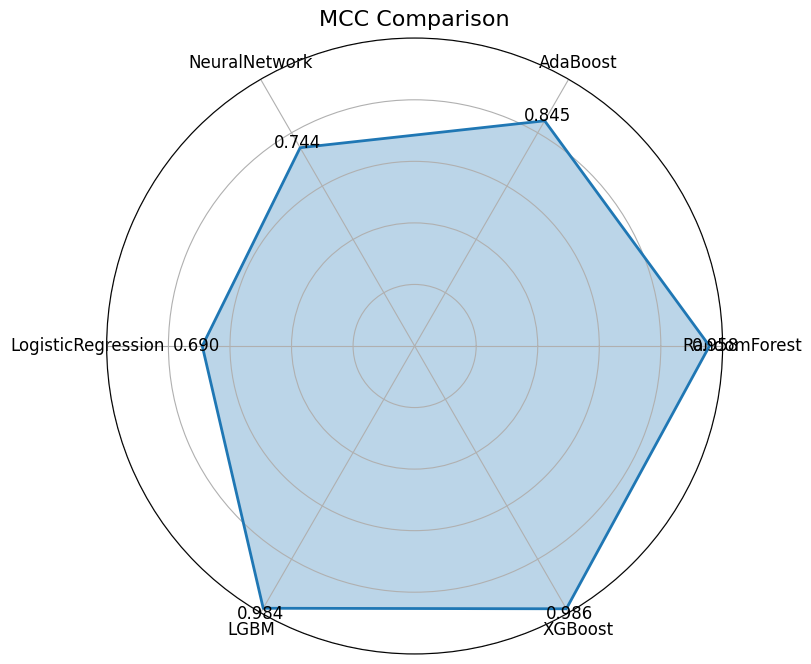

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the models and their corresponding MCC values
models = ['RandomForest', 'AdaBoost', 'NeuralNetwork', 'LogisticRegression', 'LGBM', 'XGBoost']
mcc_values = [0.958, 0.845, 0.744, 0.69, 0.984, 0.986]

# Number of models
num_models = len(models)

# Calculate the angle for each model
angles = np.linspace(0, 2 * np.pi, num_models, endpoint=False).tolist()

# Make the plot circular by appending the first value to the end
mcc_values += mcc_values[:1]
angles += angles[:1]

# Create the polar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot the data
ax.plot(angles, mcc_values, linewidth=2, linestyle='solid')

# Fill the area under the curve
ax.fill(angles, mcc_values, alpha=0.3)

# Set the labels for the models
ax.set_yticklabels([])  # Hide radial labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(models, fontsize=12)

# Add MCC values at each point
for i in range(num_models):
    ax.text(angles[i], mcc_values[i] + 0.02, f"{mcc_values[i]:.3f}", ha='center', va='center', fontsize=12)

# Title and display the plot
ax.set_title("MCC Comparison", size=16, color="black", va="bottom")

# Show the plot
plt.show()

In [ ]:
pip install --upgrade numba

ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.



     ---------------------------------------- 2.7/2.7 MB 789.4 kB/s eta 0:00:00
     ---------------------------------------- 28.1/28.1 MB 1.1 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.38.0


In [ ]:
top_10_features = importance_df["Feature"].head(10).values


In [ ]:
X_outliers_train_top10 = X_outliers_train[top_10_features]
X_regular_train_top10 = X_regular_train[top_10_features]
X_outliers_test_top10 = X_outliers_test[top_10_features]
X_regular_test_top10 = X_regular_test[top_10_features]

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Train your RandomForest model if not already done
rf_top10 = rf_regular
rf_top10.fit(X_train[top_10_features], y_train)

RandomForestClassifier(random_state=28)

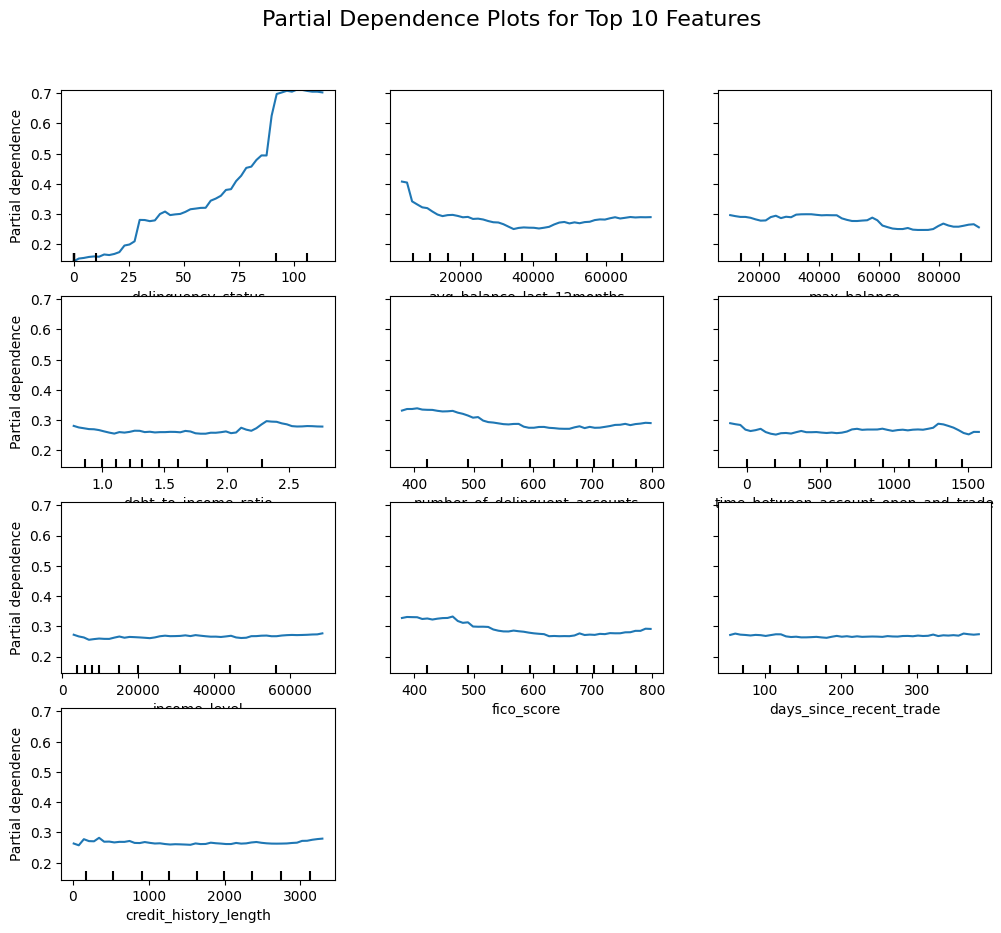

In [ ]:
# Create Partial Dependency plots
fig, ax = plt.subplots(figsize=(12, 10))
plot_partial_dependence(rf_top10, X_train[top_10_features], features=range(len(top_10_features)),
                        feature_names=top_10_features, grid_resolution=50, ax=ax)
plt.suptitle('Partial Dependence Plots for Top 10 Features', fontsize=16)
plt.subplots_adjust(top=0.9)  # Adjust title space
plt.show()